In [1]:
# Adattisztítás, táblázatok, indexelés, időbélyegek kezelése (Excel beolvasása is).
import pandas as pd
# Mátrixműveletek, kovariancia, variancia, vektoros számítások.
import numpy as np
# Regressziók (OLS), statisztikai modellek, standard error, p-érték.
import statsmodels.api as sm
# Professzionális grafikonok (itt: barplot, színek).
import seaborn as sns
# Finom grafikai kontroll (pl. tengely feliratok)
import matplotlib.pyplot as plt
# Student-t eloszlás → t-stat és p-érték kézi kiszámítása.
from scipy.stats import t as tdist
# Szebb grafikai alapbeállítás.
sns.set(style='whitegrid', context='talk')

In [29]:
# ---------------------------------------------------------
# 1. Adatok beolvasása (Az előző lépésben mentett CSV-k)
# ---------------------------------------------------------
# index_col=0 és parse_dates=True biztosítja, hogy a Dátum legyen az index
stocks_ret = pd.read_csv('data_monthly_stocks.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('data_monthly_market.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('data_monthly_rf.csv', index_col=0, parse_dates=True)

# Oszlopnevek tisztázása (hogy ne 'Close' legyen a nevük)
market_ret.columns = ['Market']  # S&P 100 (OEX)
rf_rate.columns = ['RF']         # Risk-Free Rate

# ---------------------------------------------------------
# 2. Kockázatmentes hozam kezelése (A te logikád alapján)
# ---------------------------------------------------------
rf_lag = rf_rate['RF'].shift(1)

# ---------------------------------------------------------
# 3. Többlethozam (Excess Return) számolás
# ---------------------------------------------------------
# A) Részvények többlethozama (Ri - Rf)
stock_excess_ret = stocks_ret.sub(rf_lag, axis=0)

# B) Piaci index többlethozama (Rm - Rf)
market_excess_ret = market_ret['Market'] - rf_lag

# ---------------------------------------------------------
# 4. Adatok összefűzése egy DataFrame-be
# ---------------------------------------------------------
# Létrehozunk egy közös táblát:
RP_aligned = stock_excess_ret.copy()
RP_aligned.insert(0, 'Market_rp', market_excess_ret)

# 5. Tisztítás (MÓDOSÍTVA)
# Csak azokat a sorokat dobjuk el, ahol a PIACI hozam (Market) hiányzik.
# A részvényeknél maradhat NaN, azt majd a függvényben kezeljük.
RP_aligned = RP_aligned.dropna(subset=['Market_rp'])

In [30]:
# === First-Pass Regresszió (Javított, Robosztus verzió) ===
def excel_first_pass(RP, start, end, min_obs=24):
    """
    Kiszámolja a Béta, Alfa és Sigma^2 értékeket.
    Kezeli, ha egy részvénynél hiányzik adat (nem dobja el az egész sort).
    min_obs: Minimum ennyi hónapnyi adat kell egy részvényhez, különben kihagyja.
    """
    # 1. Időszak kivágása
    RP_period = RP.loc[start:end]
    RM_all = RP_period['Market_rp']
    
    rows = []
    
    # 2. Végigmegyünk minden oszlopon (részvényen)
    for s in RP_period.columns:
        if s == 'Market_rp': 
            continue
            
        Ri_all = RP_period[s] 
        
        # --- FONTOS VÁLTOZÁS: EGYEDI SZŰRÉS (MASZKOLÁS) ---
        # Csak azokat a hónapokat nézzük, ahol ennél a részvénynél ÉS a piacnál is van adat
        mask = Ri_all.notna() & RM_all.notna()
        
        # Ha túl kevés az adat (pl. kevesebb mint 2 év), kihagyjuk a részvényt
        if mask.sum() < min_obs:
            continue
            
        # Kiválasztjuk a tisztított adatokat a számításhoz
        Ri = Ri_all[mask]
        RM = RM_all[mask]
        
        # Kovariancia és Variancia számítás
        cov = np.cov(Ri, RM)[0, 1]
        var_m = np.var(RM, ddof=1)
        
        # Béta és Alfa számítás
        beta = cov / var_m
        alpha = Ri.mean() - beta * RM.mean()
        
        # Egyedi kockázat (Sigma^2)
        # Fontos: A residuumot is a szűrt adatokon számoljuk
        resid = Ri - (alpha + beta * RM)
        sigma2 = np.var(resid, ddof=1)
        
        # P-érték számolása az alfára
        try:
            model = sm.OLS(Ri, sm.add_constant(RM)).fit()
            alpha_pval = model.pvalues['const']
        except:
            alpha_pval = np.nan
        
        rows.append([s, beta, alpha, sigma2, Ri.mean(), alpha_pval])
    
    return pd.DataFrame(rows, columns=['Ticker', 'beta', 'alpha', 'sigma2', 'riskprem_mean', 'alpha_pval'])

# --- VÁLTOZÓK ÉS FUTTATÁS ---
start_date = '2000-01-01'  # Most már bátran állíthatod korábbra is!
end_date = '2025-12-31'

# Függvény meghívása
first_pass_results = excel_first_pass(RP_aligned, start_date, end_date)

# Szignifikancia jelölése
first_pass_results['significant'] = first_pass_results['alpha_pval'] < 0.05

print(f"Elemzett részvények száma: {len(first_pass_results)}")
print("First-pass regresszió eredményei (első 5 sor):")
print(first_pass_results.head())

Elemzett részvények száma: 100
First-pass regresszió eredményei (első 5 sor):
  Ticker      beta     alpha    sigma2  riskprem_mean  alpha_pval  significant
0   AAPL  1.396238  0.019514  0.008542       0.022944    0.000379         True
1   ABBV  0.754241  0.008668  0.004589       0.015210    0.147609        False
2    ABT  0.514030  0.006539  0.002736       0.007802    0.034057         True
3    ACN  1.135291  0.008048  0.002849       0.012052    0.013616         True
4   ADBE  1.340674  0.011956  0.008852       0.015250    0.031236         True


Adatok sikeresen betöltve az RP_aligned táblából.
Regressziók futtatása...


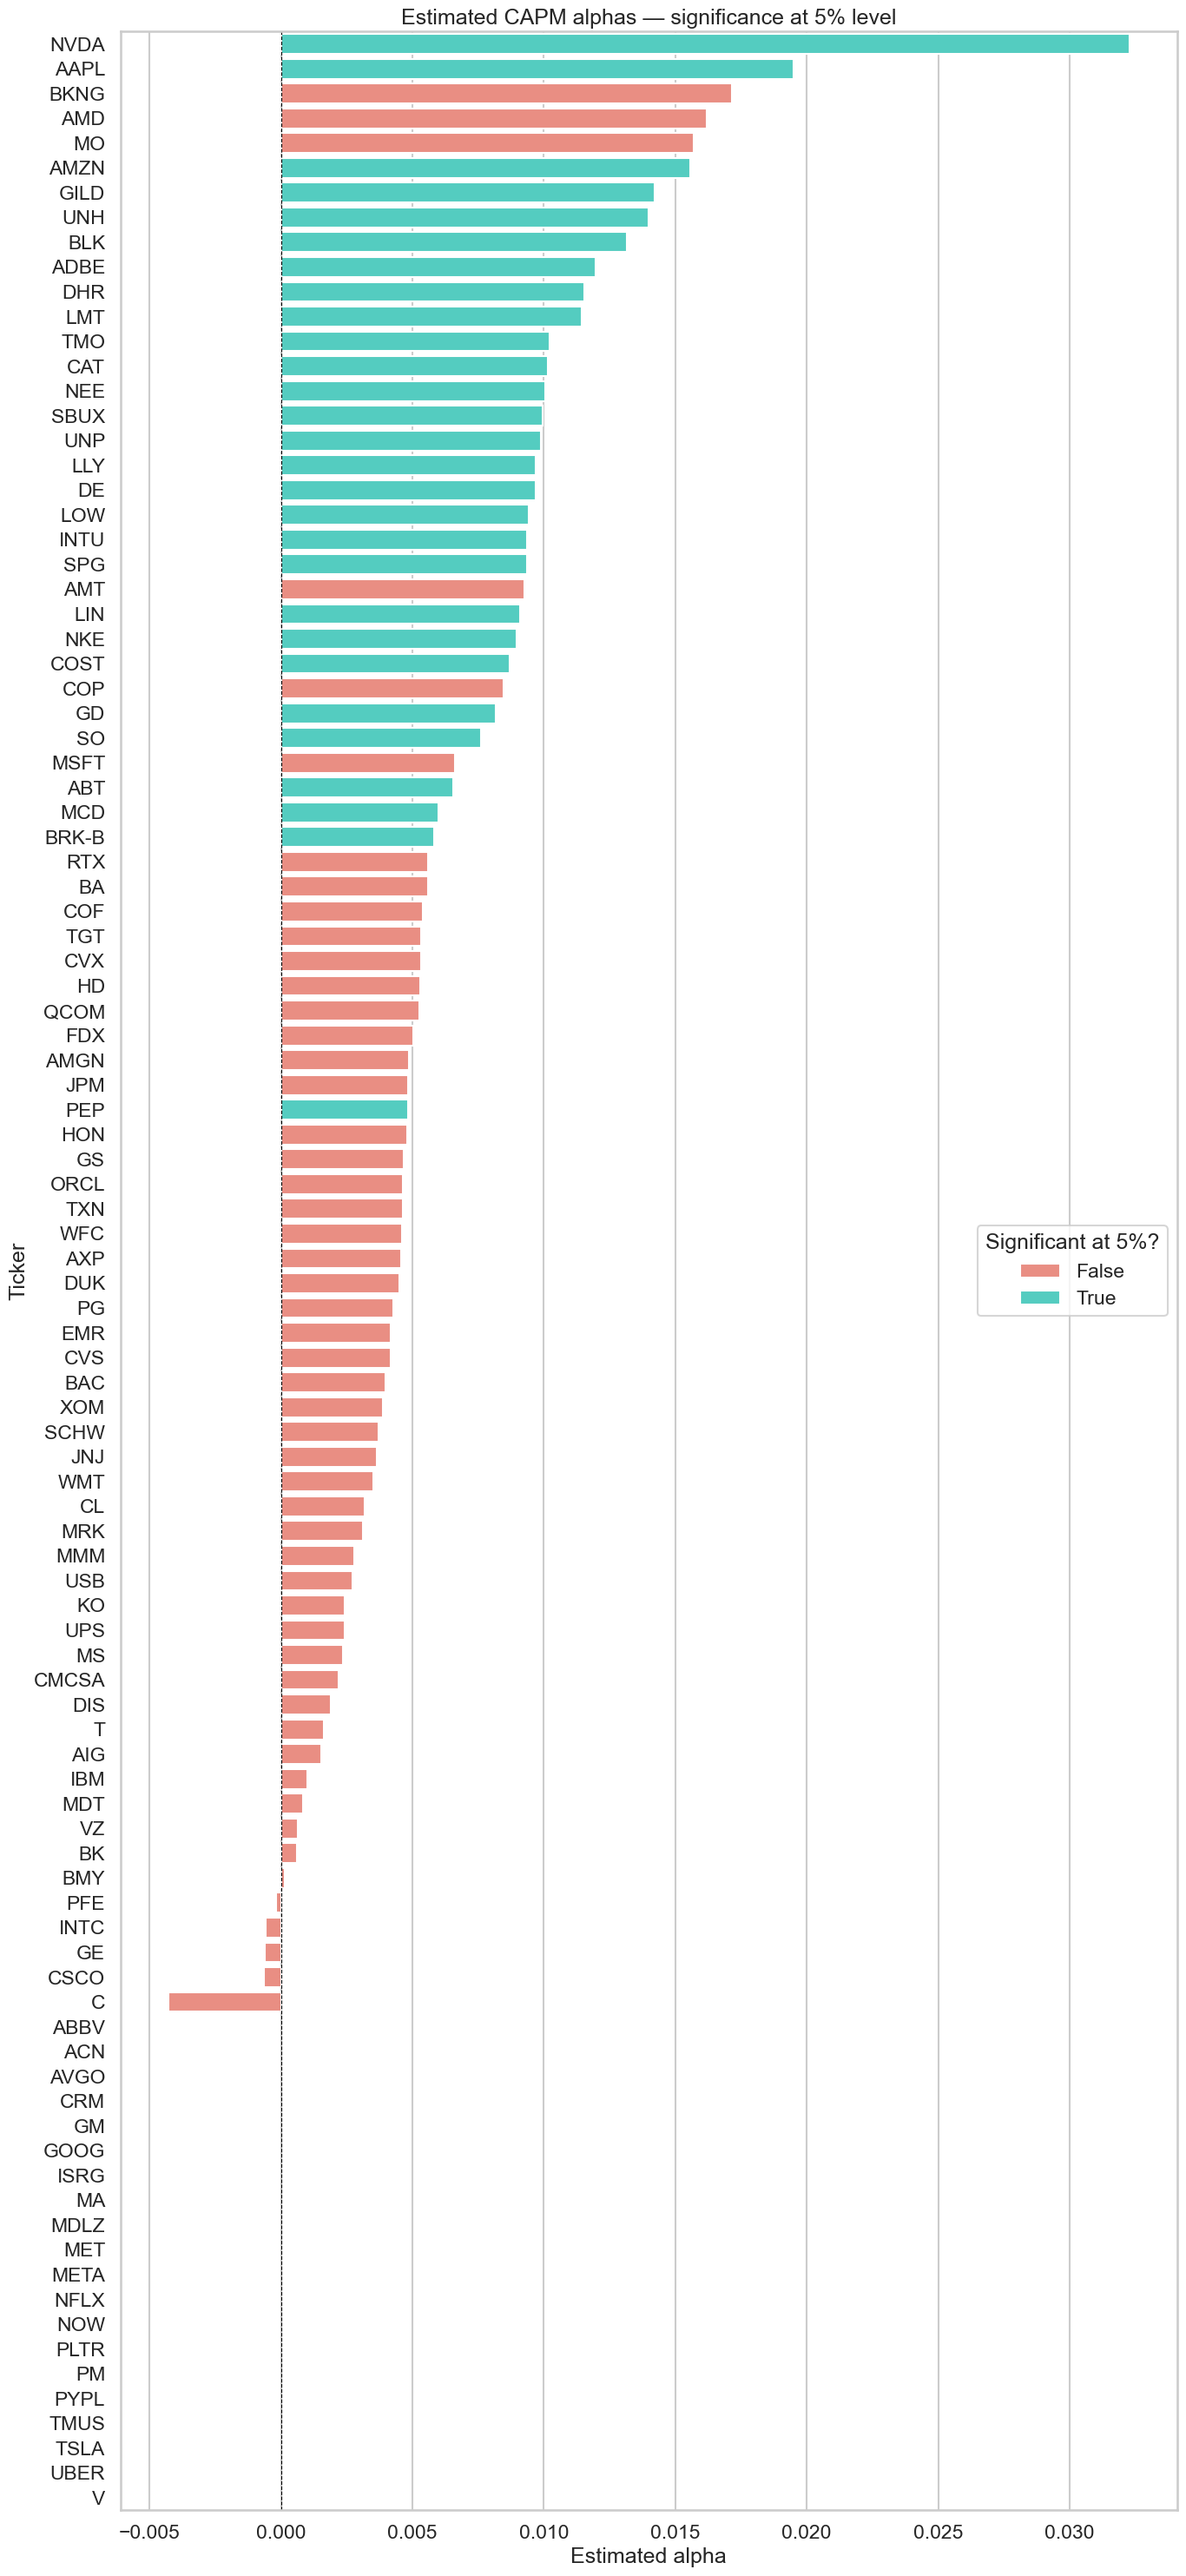

In [31]:
# 1. Adatok kinyerése az RP_aligned-ből
excess_market = RP_aligned['Market_rp']  # Ez a piaci prémium (Rm - Rf)
excess_stocks = RP_aligned.drop(columns=['Market_rp']) # Ezek a részvények prémiumai (Ri - Rf)

print("Adatok sikeresen betöltve az RP_aligned táblából.")

# --- 2. PARAMÉTEREK BECSLÉSE (First Pass) ---
# Szükségünk van az Alphákra és a Sigma^2-re (egyedi kockázat)
results_list = []

# Piaci hozam statisztikái a képletedhez
RM = excess_market
RM_mean = RM.mean()
RM_var = RM.var(ddof=1)
N = len(RM)

print("Regressziók futtatása...")
for stock in excess_stocks.columns:
    Y = excess_stocks[stock]
    X = sm.add_constant(RM) # Konstans hozzáadása az Alphához
    
    model = sm.OLS(Y, X).fit()
    
    # Eredmények kinyerése
    alpha = model.params.iloc[0]
    beta = model.params.iloc[1]
    sigma2 = np.var(model.resid) # Reziduális variancia
    
    results_list.append({
        'Ticker': stock,
        'beta': beta,
        'alpha': alpha,
        'sigma2': sigma2
    })

# DataFrame a plotoláshoz
plot_df = pd.DataFrame(results_list)

# --- 3. STATISZTIKAI SZÁMÍTÁS (A te logikád alapján) ---
# Alpha Standard Error számítása az általad megadott képlettel
plot_df['alpha_se'] = np.sqrt(
    plot_df['sigma2'] * (1 + (RM_mean**2)/RM_var) / N
)

# t-statisztika (H0: alpha = 0)
plot_df['tstat'] = plot_df['alpha'] / plot_df['alpha_se']

# p-érték (kétoldali)
plot_df['pval'] = 2 * (1 - tdist.cdf(np.abs(plot_df['tstat']), df=N-2))

# Szignifikancia (5%-os szint)
plot_df['significant'] = plot_df['pval'] < 0.05

# Rendezés a szép ábrához
plot_df = plot_df.sort_values('alpha', ascending=False)

# --- 4. VIZUALIZÁCIÓ ---
plt.figure(figsize=(14, 30)) # Magasabb ábra, hogy minden elférjen
sns.barplot(
    data=plot_df,
    y='Ticker',
    x='alpha',
    hue='significant',
    palette={True: 'turquoise', False: 'salmon'},
    dodge=False
)

plt.title('Estimated CAPM alphas — significance at 5% level')
plt.xlabel('Estimated alpha')
plt.ylabel('Ticker')
plt.legend(title='Significant at 5%?')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [32]:
# --- 1. HIBA JAVÍTÁSA: A hiányzó 'valid' változó definiálása ---
# A first_pass_results táblát használjuk a keresztmetszeti vizsgálathoz
valid = first_pass_results.copy()

print("Adatok előkészítve a Second-pass regresszióhoz.")

# ---------------------------------------------------------
# --- 2. Second-pass Regressziók (Keresztmetszeti) ---
# ---------------------------------------------------------

# Modell 1: Csak a Béta magyarázza a hozamokat?
# CAPM szerint: Ri = gamma0 + gamma1 * Beta
print("\n--- Model 1: Risk Premium ~ Beta ---")
y = valid['riskprem_mean']
X1 = sm.add_constant(valid['beta'])

model1 = sm.OLS(y, X1).fit()
print(model1.summary())

# Modell 2: A Béta mellett az egyedi kockázat (Sigma^2) is számít?
# CAPM szerint a Sigma^2 nem kéne, hogy szignifikáns legyen.
print("\n" + "="*80 + "\n")
print("--- Model 2: Risk Premium ~ Beta + Sigma^2 ---")
X2 = sm.add_constant(valid[['beta', 'sigma2']])

model2 = sm.OLS(y, X2).fit()
print(model2.summary())

Adatok előkészítve a Second-pass regresszióhoz.

--- Model 1: Risk Premium ~ Beta ---
                            OLS Regression Results                            
Dep. Variable:          riskprem_mean   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     34.96
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           4.92e-08
Time:                        11:02:01   Log-Likelihood:                 346.58
No. Observations:                 100   AIC:                            -689.2
Df Residuals:                      98   BIC:                            -684.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [33]:
from IPython.display import display  
# ---------------------------------------------------------
# SECOND PASS: Keresztmetszeti Regressziók
# ---------------------------------------------------------

print("Futtatás kész. Eredmények megjelenítése...")

# --- Model 1: Csak Béta ---
# Y = Átlagos hozam, X = Béta
y = valid['riskprem_mean']
X1 = sm.add_constant(valid[['beta']])

model1 = sm.OLS(y, X1).fit()

print("\n=== Model 1: Risk Premium ~ Beta ===")
display(model1.summary())


# --- Model 2: Béta és Sigma^2 ---
# Y = Átlagos hozam, X = Béta + Sigma^2
X2 = sm.add_constant(valid[['beta', 'sigma2']])

model2 = sm.OLS(y, X2).fit()

print("\n" + "="*80 + "\n") # Elválasztó vonal
print("=== Model 2: Risk Premium ~ Beta + Sigma^2 ===")
display(model2.summary())

Futtatás kész. Eredmények megjelenítése...

=== Model 1: Risk Premium ~ Beta ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          riskprem_mean   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     34.96
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           4.92e-08
Time:                        11:02:03   Log-Likelihood:                 346.58
No. Observations:                 100   AIC:                            -689.2
Df Residuals:                      98   BIC:                            -684.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.266      0.791      -0.003       0.004
beta           0.0105      0.002      5.912      0.000       0.007       0.014
==============================================================================
Omnibus:                       17.995   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.491
Skew:                           0.898   Prob(JB):                     7.92e-06
Kurtosis:                       4.552   Cond. No.                         4.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



=== Model 2: Risk Premium ~ Beta + Sigma^2 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          riskprem_mean   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     49.97
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.21e-15
Time:                        11:02:03   Log-Likelihood:                 366.74
No. Observations:                 100   AIC:                            -727.5
Df Residuals:                      97   BIC:                            -719.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.002      3.132      0.002       0.002       0.009
beta           0.0017      0.002      0.858      0.393      -0.002       0.006
sigma2         0.5282      0.076      6.940      0.000       0.377       0.679
==============================================================================
Omnibus:                       13.638   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.719
Skew:                           0.586   Prob(JB):                     1.92e-05
Kurtosis:                       4.959   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
#-------------------------
# HIPOTÉZIS VIZSGÁLAT
# ---------------------------------------------------------
print('=== CAPM HYPOTHESIS TESTS ===')

# Piaci átlagos többlethozam (Ezt hasonlítjuk a becsült gammához)
market_rp = excess_market.mean()
n = valid.shape[0]

# --- Model 1 (Beta only) ---
gamma1_1 = model1.params['beta']
se1 = model1.bse['beta']
df1 = n - 2

# t-test: H0: gamma1 = market_rp
t1 = (gamma1_1 - market_rp) / se1
p1 = 2 * (1 - tdist.cdf(abs(t1), df1))

print('\nModel 1 (beta only)')
print(f'gamma1 = {gamma1_1}')
print(f'market rp = {market_rp}')
print(f't-stat = {t1}')
print(f'p-value = {p1}')

# --- Model 2 (Beta + Sigma2) ---
gamma1_2 = model2.params['beta']
se2 = model2.bse['beta']
df2 = n - 3

# t-test: H0: gamma1 = market_rp
t2 = (gamma1_2 - market_rp) / se2
p2 = 2 * (1 - tdist.cdf(abs(t2), df2))

print('\nModel 2 (beta + sigma2)')
print(f'gamma1 = {gamma1_2}')
print(f'market rp = {market_rp}')
print(f't-stat = {t2}')
print(f'p-value = {p2}')

=== CAPM HYPOTHESIS TESTS ===

Model 1 (beta only)
gamma1 = 0.010545320596718566
market rp = 0.0024567173267295035
t-stat = 4.534994832461901
p-value = 1.632737887691249e-05

Model 2 (beta + sigma2)
gamma1 = 0.001668006787038252
market rp = 0.0024567173267295035
t-stat = -0.40546703325477607
p-value = 0.6860271822146078


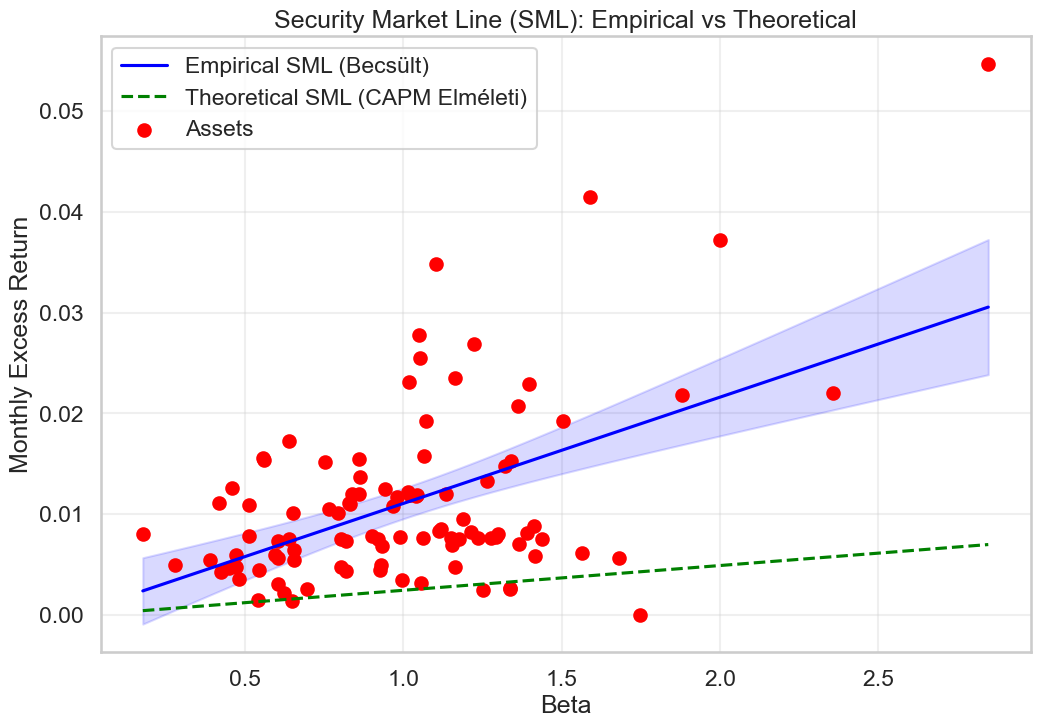

In [35]:
# Változók kinyerése
betas = valid['beta']
y_m = valid['riskprem_mean']
beta_grid = np.linspace(betas.min(), betas.max(), 200)
X_pred = sm.add_constant(beta_grid)
pred = model1.get_prediction(X_pred)
ci = pred.conf_int()
y_pred = pred.predicted_mean
lower, upper = ci[:, 0], ci[:, 1]

# Vizualizáció
plt.figure(figsize=(12, 8))

# Empirikus SML 
plt.plot(beta_grid, y_pred, label='Empirical SML (Becsült)', color='blue')
plt.fill_between(beta_grid, lower, upper, color='blue', alpha=0.15)

# Elméleti SML 
theoretical_sml = excess_market.mean() * beta_grid
plt.plot(beta_grid, theoretical_sml, label='Theoretical SML (CAPM Elméleti)', color='green', linestyle='--')

# Tényleges részvények (Pöttyök)
plt.scatter(betas, y_m, color='red', label='Assets')

plt.xlabel('Beta')
plt.ylabel('Monthly Excess Return')
plt.title('Security Market Line (SML): Empirical vs Theoretical')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

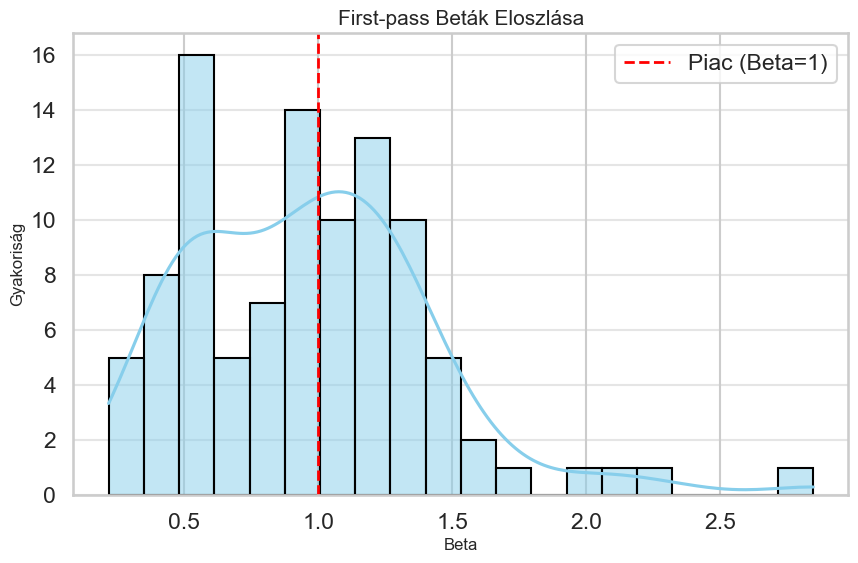

First-pass regresszió eredményei (első 5 sor):
  Ticker      beta     alpha    sigma2  riskprem_mean  alpha_pval
0   AAPL  1.220523  0.000551  0.002245       0.012655    0.940802
1   ABBV  0.574846  0.012046  0.004404       0.017747    0.249741
2    ABT  0.678538 -0.007337  0.002259      -0.000608    0.326628
3    ACN  1.313286 -0.005886  0.002089       0.007138    0.412376
4   ADBE  1.513033 -0.014011  0.005211       0.000994    0.218957


In [24]:
# 3. FUTTATÁS ÉS ÁBRÁZOLÁS
# Függvény meghívása
first_pass_results = excel_first_pass(RP_aligned, '2020-01-01', '2025-11-01')

# Hisztogram készítése
plt.figure(figsize=(10, 6))
sns.histplot(data=first_pass_results, x='beta', bins=20, kde=True, color='skyblue', edgecolor='black')

# Díszítés
plt.title('First-pass Beták Eloszlása', fontsize=15)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Piac (Beta=1)')
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.show()

# Eredmények kiírása ellenőrzésképp
print("First-pass regresszió eredményei (első 5 sor):")
print(first_pass_results.head())

P-értékek számolása a hőtérképhez...
Hiba a 2000-01-01 - 2021-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2000-01-01 - 2022-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2000-01-01 - 2023-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2000-01-01 - 2024-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2000-01-01 - 2025-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2005-01-01 - 2024-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2005-01-01 - 2025-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2010-01-01 - 2024-11-01 időszaknál: zero-size array to reduction operation maximum which has no identity
Hiba a 2010-01-01 - 2025-11-01 időszaknál: zero-size array to reduc

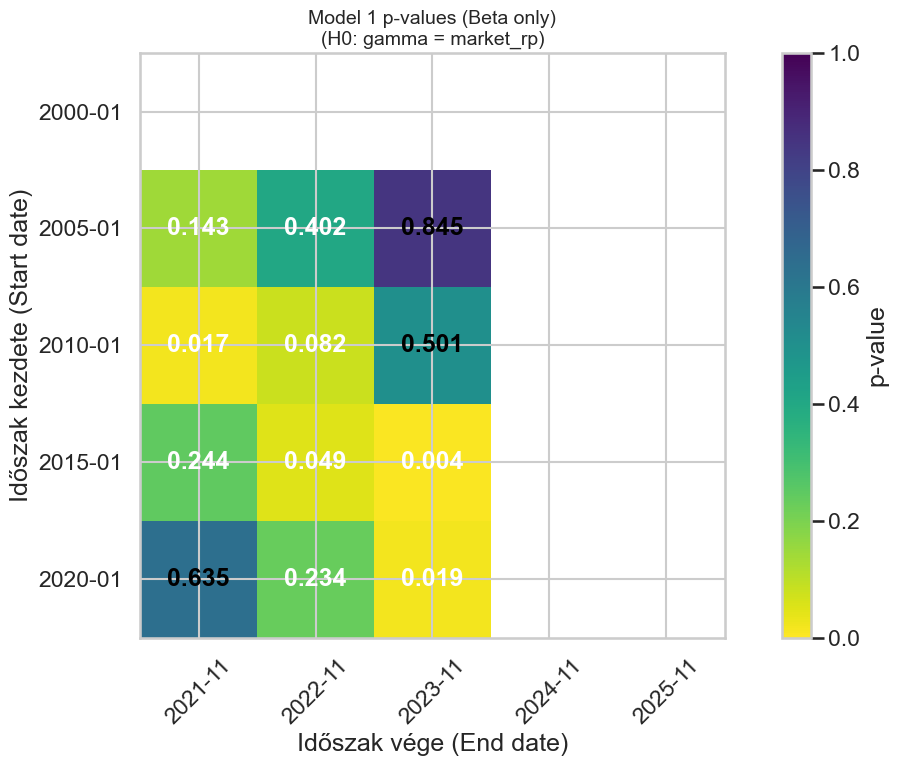

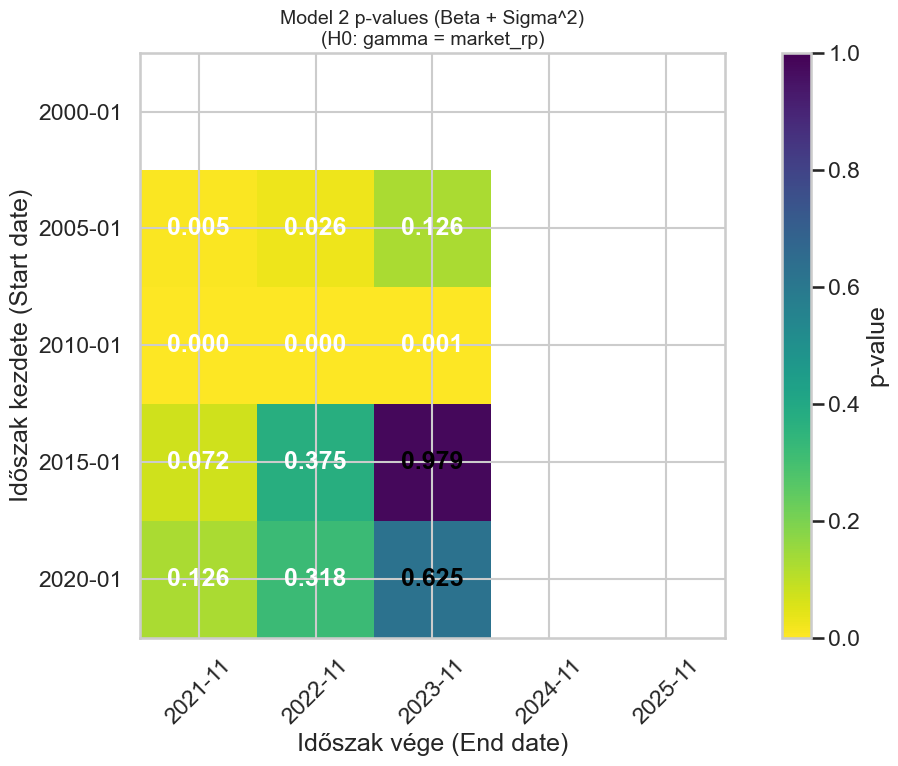

In [48]:
# 1. Függvény definiálása (a te adataidhoz igazítva)
def excel_first_pass_heatmap(RP, start, end):
    # Időszak szűrése
    RPsub = RP.loc[start:end]
    RM = RPsub['Market_rp'] # A te piaci prémium oszlopod
    
    rows = []
    for s in RPsub.columns:
        if s == 'Market_rp': 
            continue
            
        Ri = RPsub[s]
        # Kovariancia és béta számítás
        cov = np.cov(Ri, RM)[0, 1]
        var = np.var(RM, ddof=1)
        beta = cov / var
        
        # Alfa és Sigma^2 (reziduális variancia)
        alpha = Ri.mean() - beta * RM.mean()
        # A snippet logikája szerinti sigma2 számítás:
        sigma2 = np.var(Ri - beta * RM, ddof=1) 
        
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    
    return pd.DataFrame(rows, columns=['Ticker', 'beta', 'alpha', 'sigma2', 'riskprem_mean'])

# 2. Dátumok beállítása a te 2020-2025-ös időszakodhoz
# Ezeket a dátumokat a te RP_aligned indexed alapján választottam
starts = [
    "2000-01-01",
    "2005-01-01",
    "2010-01-01",
    "2015-01-01",
    "2020-01-01"
]

ends = [
    "2021-11-01",
    "2022-11-01",
    "2023-11-01",
    "2024-11-01",
    "2025-11-01"
]

# 3. Mátrixok előkészítése
pvals1 = np.zeros((len(starts), len(ends)))
pvals2 = np.zeros((len(starts), len(ends)))

print("P-értékek számolása a hőtérképhez...")

# 4. Ciklus a különböző időablakokra
for i, s in enumerate(starts):
    for j, e in enumerate(ends):
        try:
            # First pass az adott ablakra
            first = excel_first_pass_heatmap(RP_aligned, s, e)
            
            # Adatok tisztítása
            valid = first.set_index('Ticker').dropna()
            y = valid['riskprem_mean']
            n = valid.shape[0]
            
            # Piaci prémium átlaga az adott időszakon (a teszthez kell)
            market_rp = RP_aligned['Market_rp'].loc[s:e].mean()

            # --- Model 1: Csak Béta ---
            X1 = sm.add_constant(valid[['beta']])
            model1 = sm.OLS(y, X1).fit()
            
            gamma1_1 = model1.params['beta']
            se1 = model1.bse['beta']
            # t-test: H0: gamma1 = market_rp
            t1 = (gamma1_1 - market_rp) / se1
            p1 = 2 * (1 - tdist.cdf(abs(t1), df=n-2))

            # --- Model 2: Béta + Sigma^2 ---
            X2 = sm.add_constant(valid[['beta', 'sigma2']])
            model2 = sm.OLS(y, X2).fit()
            
            gamma1_2 = model2.params['beta']
            se2 = model2.bse['beta']
            # t-test: H0: gamma1 = market_rp
            t2 = (gamma1_2 - market_rp) / se2
            p2 = 2 * (1 - tdist.cdf(abs(t2), df=n-3))

            pvals1[i, j] = p1
            pvals2[i, j] = p2
            
        except Exception as err:
            print(f"Hiba a {s} - {e} időszaknál: {err}")
            pvals1[i, j] = np.nan
            pvals2[i, j] = np.nan

# 5. Hőtérkép rajzoló függvény
def plot_heatmap(mat, title):
    plt.figure(figsize=(12, 8))
    # NaN értékek kezelése (ha lenne)
    if np.isnan(mat).all():
        print(f"Nincs megjeleníthető adat a '{title}' ábrához.")
        return
        
    im = plt.imshow(mat, cmap='viridis_r', vmin=0, vmax=1) # Fordított színskála, hogy a kis p-érték legyen sötét/feltűnő
    plt.colorbar(im, label='p-value')
    
    # Értékek ráírása a cellákra
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if not np.isnan(mat[i, j]):
                # Fehér vagy fekete szöveg a háttér sötétségétől függően
                color = 'white' if mat[i, j] < 0.5 else 'black'
                plt.text(j, i, f'{mat[i, j]:.3f}', ha='center', va='center', color=color, fontweight='bold')
    
    plt.title(title, fontsize=14)
    plt.xticks(range(len(ends)), [e[:7] for e in ends], rotation=45) # Csak ÉÉÉÉ-HH
    plt.yticks(range(len(starts)), [s[:7] for s in starts])
    plt.xlabel("Időszak vége (End date)")
    plt.ylabel("Időszak kezdete (Start date)")
    plt.tight_layout()
    plt.show()

# 6. Ábrázolás
plot_heatmap(pvals1, "Model 1 p-values (Beta only)\n(H0: gamma = market_rp)")
plot_heatmap(pvals2, "Model 2 p-values (Beta + Sigma^2)\n(H0: gamma = market_rp)")

In [37]:
def get_gamma_pvalues_safe(df_aligned, start_date, end_date):
    """
    Kiszámolja a CAPM teszteléséhez szükséges gamma p-értékeket egy adott időszakon.
    Lépések:
    1. Időszak szűrése.
    2. Idősoros regressziók (Time Series) -> Béták becslése minden részvényre.
    3. Keresztmetszeti regresszió (Cross-Sectional) -> Átlaghozam ~ Béta + Béta^2
    """
    
    # Időszak szűrése
    subset = df_aligned.loc[start_date:end_date]
    
    # Piaci többlethozam és Részvények szétválasztása
    market_rp = subset['Market_rp']
    stock_rps = subset.drop(columns=['Market_rp'])
    
    betas = []
    avg_excess_returns = []
    
    # --- 1. Lépés: Béták meghatározása (Idősoros regressziók) ---
    X_ts = sm.add_constant(market_rp) # Konstans a piachoz
    
    for stock in stock_rps.columns:
        y_ts = stock_rps[stock]
        
        # Csak azokat a sorokat használjuk, ahol van adat (NaN kezelés)
        mask = y_ts.notna() & market_rp.notna()
        
        # Ha túl kevés adat van (pl. < 12 hónap), kihagyjuk a részvényt
        if mask.sum() < 12:
            continue
            
        # Regresszió futtatása
        model_ts = sm.OLS(y_ts[mask], X_ts[mask]).fit()
        
        # Béta kinyerése (a 2. paraméter, mert az 1. a konstans/alfa)
        beta_i = model_ts.params.iloc[1]
        
        betas.append(beta_i)
        avg_excess_returns.append(y_ts[mask].mean())

    # --- 2. Lépés: Keresztmetszeti regresszió (Gamma becslés) ---
    # Modell: R_i_átlag = gamma0 + gamma1 * beta_i + gamma2 * beta_i^2
    
    n = len(betas)
    if n < 10: # Ha túl kevés részvény maradt
        return [np.nan, np.nan, np.nan]

    # Adatok előkészítése
    X_cs = pd.DataFrame({
        'Beta': betas,
        'Beta_Sq': [b**2 for b in betas] # Négyzetes tag a linearitás teszteléséhez
    })
    X_cs = sm.add_constant(X_cs) # gamma0 (tengelymetszet)
    y_cs = pd.Series(avg_excess_returns)
    
    # Másodlagos regresszió futtatása
    model_cs = sm.OLS(y_cs, X_cs).fit()
    
    # P-értékek visszaadása (const, Beta, Beta_Sq)
    return model_cs.pvalues.values

# 1. Adatok újraépítése (Törlés / dropna NÉLKÜL)
# Feltételezzük, hogy a stocks_ret, market_ret, rf_rate már be van olvasva

# Újrakalkuláljuk a többlethozamokat, de NEM dobunk el sorokat
rf_lag = rf_rate['RF'].shift(1)

# A) Részvények többlethozama (Ri - Rf)
# A fill_value=None fontos, hogy ne nullával töltse fel a hiányzókat, hanem maradjon NaN
stock_excess_ret = stocks_ret.sub(rf_lag, axis=0)

# B) Piaci index többlethozama (Rm - Rf)
market_excess_ret = market_ret['Market'] - rf_lag

# C) Összefűzés
RP_aligned = stock_excess_ret.copy()
RP_aligned.insert(0, 'Market_rp', market_excess_ret)

# --- ELLENŐRZÉS ---
# Nézzük meg, mikor kezdődik a tényleges adat!
print("Adatok kezdete (Market_rp első nem üres adata):", RP_aligned['Market_rp'].first_valid_index())
print("Adatsorok száma:", len(RP_aligned))

# 2. Most futtasd újra a p-érték számítást az ÚJ RP_aligned táblán
# (Győződj meg róla, hogy a get_gamma_pvalues_safe függvény definiálva van a memóriában)

p_vals_full = get_gamma_pvalues_safe(RP_aligned, '2000-01-01', '2025-11-01')
p_2000_2015 = get_gamma_pvalues_safe(RP_aligned, '2000-01-01', '2015-12-31')
p_2005_2020 = get_gamma_pvalues_safe(RP_aligned, '2005-01-01', '2020-12-31')
p_2010_2025 = get_gamma_pvalues_safe(RP_aligned, '2010-01-01', '2025-11-01')

summary_p = pd.DataFrame({
    "Teljes (2000–2025)": p_vals_full,
    "2000–2015":          p_2000_2015,
    "2005–2020":          p_2005_2020,
    "2010–2025":          p_2010_2025,
}, index=["p(γ0≈0)", "p(γ1≈0)", "p(γ2≈0)"])

print("\nJavított eredmények:")
summary_p

Adatok kezdete (Market_rp első nem üres adata): 2000-02-01 00:00:00
Adatsorok száma: 310

Javított eredmények:


,Teljes (2000–2025),2000–2015,2005–2020,2010–2025
p(γ0≈0),0.005035,0.026948,0.761447,0.000184
p(γ1≈0),0.235371,0.994762,0.008708,0.117474
p(γ2≈0),0.001440,0.948641,0.016806,0.000044


In [54]:
import pandas as pd

# 1. Betöltjük a részvényhozamokat
stock_returns = pd.read_csv('data_monthly_stocks.csv', index_col=0, parse_dates=True)

# 2. A GICS szektor besorolás (S&P 100 - 2025 aktuális állapot)
sector_map = {
    # Communication Services (Kommunikációs szolgáltatások)
    'CMCSA': 'Communication Services', 'DIS': 'Communication Services', 'GOOG': 'Communication Services',
    'META': 'Communication Services', 'NFLX': 'Communication Services', 'T': 'Communication Services',
    'TMUS': 'Communication Services', 'VZ': 'Communication Services',
    
    # Consumer Discretionary (Ciklikus fogyasztási javak)
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'GM': 'Consumer Discretionary',
    'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 'MCD': 'Consumer Discretionary',
    'NKE': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 'TGT': 'Consumer Discretionary',
    'TSLA': 'Consumer Discretionary',
    
    # Consumer Staples (Nem ciklikus fogyasztási javak)
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples',
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples',
    'PG': 'Consumer Staples', 'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    
    # Energy (Energia)
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    
    # Financials (Pénzügy) [Megj: Visa, Mastercard, PayPal ide tartoznak 2023 óta]
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials',
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials',
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials',
    'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials',
    'V': 'Financials', 'WFC': 'Financials',
    
    # Health Care (Egészségügy)
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care',
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care',
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care',
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    
    # Industrials (Ipari) [Megj: Uber ide tartozik]
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials',
    'FDX': 'Industrials', 'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials',
    'LMT': 'Industrials', 'MMM': 'Industrials', 'RTX': 'Industrials', 'UBER': 'Industrials',
    'UNP': 'Industrials', 'UPS': 'Industrials',
    
    # Information Technology (Informatika)
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology',
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CRM': 'Information Technology',
    'CSCO': 'Information Technology', 'IBM': 'Information Technology', 'INTC': 'Information Technology',
    'INTU': 'Information Technology', 'MSFT': 'Information Technology', 'NOW': 'Information Technology',
    'NVDA': 'Information Technology', 'ORCL': 'Information Technology', 'PLTR': 'Information Technology',
    'QCOM': 'Information Technology', 'TXN': 'Information Technology',
    
    # Materials (Alapanyagok)
    'LIN': 'Materials',
    
    # Real Estate (Ingatlan)
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    
    # Utilities (Közművek)
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

# 3. Csoportosítás és átlagolás (Szektor portfóliók létrehozása)
# Transzponáljuk, hogy a sorok legyenek a tickerek, majd groupolunk a map alapján
sector_returns = stock_returns.T.groupby(sector_map).mean().T

# Kiíratás ellenőrzésképpen
print("Elkészült szektorok:")
print(sector_returns.columns.tolist())

# Az első 5 sor megtekintése
sector_returns.head()

Elkészült szektorok:
['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
Date,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,-0.113521,-0.051674,-0.083648,-0.088468,-0.057039,-0.010462,-0.092012,0.248325,-0.171779,0.159829,-0.126957
2000-03-01,0.152355,0.232613,0.003282,0.171202,0.191782,0.064236,0.118464,0.155676,0.233334,0.010292,0.098574
2000-04-01,0.006171,-0.122417,0.031866,-0.019146,-0.021907,0.062927,0.053869,-0.048031,0.072654,0.017095,0.074717
2000-05-01,-0.044679,-0.089886,0.015181,0.124502,0.034706,0.029302,-0.010207,-0.092174,-0.054852,-0.119770,0.054679


In [55]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- 1. ADATOK BETÖLTÉSE (Ha még nincsenek a memóriában) ---
# stock_returns = pd.read_csv('data_monthly_stocks.csv', index_col=0, parse_dates=True)
# market_ret = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
# rf_rate = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# --- 2. AZ ÁLTALAD MEGADOTT SZEKTOR BESOROLÁS ---
sector_map = {
    'CMCSA': 'Communication Services', 'DIS': 'Communication Services', 'GOOG': 'Communication Services',
    'META': 'Communication Services', 'NFLX': 'Communication Services', 'T': 'Communication Services',
    'TMUS': 'Communication Services', 'VZ': 'Communication Services',
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'GM': 'Consumer Discretionary',
    'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 'MCD': 'Consumer Discretionary',
    'NKE': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 'TGT': 'Consumer Discretionary',
    'TSLA': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples',
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples',
    'PG': 'Consumer Staples', 'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials',
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials',
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials',
    'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials',
    'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care',
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care',
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care',
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials',
    'FDX': 'Industrials', 'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials',
    'LMT': 'Industrials', 'MMM': 'Industrials', 'RTX': 'Industrials', 'UBER': 'Industrials',
    'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology',
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CRM': 'Information Technology',
    'CSCO': 'Information Technology', 'IBM': 'Information Technology', 'INTC': 'Information Technology',
    'INTU': 'Information Technology', 'MSFT': 'Information Technology', 'NOW': 'Information Technology',
    'NVDA': 'Information Technology', 'ORCL': 'Information Technology', 'PLTR': 'Information Technology',
    'QCOM': 'Information Technology', 'TXN': 'Information Technology',
    'LIN': 'Materials',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

# --- 3. SZEKTOR PORTFÓLIÓK LÉTREHOZÁSA ---
# Transzponáljuk, hogy a sorok legyenek a tickerek, majd groupolunk a map alapján
sector_returns = stock_returns.T.groupby(sector_map).mean().T

print("Iparági portfóliók elkészültek:", sector_returns.columns.tolist())

# --- 4. CAPM REGRESSZIÓ FUTTATÁSA AZ IPARÁGAKRA ---

# Előkészítjük a piaci többlethozamot (Market Excess Return)
# Figyelünk az időbeli illeszkedésre
common_index = sector_returns.index.intersection(market_ret.index).intersection(rf_rate.index)

# Szűrés a közös időszakra
sec_ret = sector_returns.loc[common_index]
mkt_ret = market_ret.loc[common_index, 'Market'] # Feltételezve, hogy 'Market' az oszlop neve
rf = rf_rate.loc[common_index, 'RF'] # Feltételezve, hogy 'RF' az oszlop neve

# Piaci prémium (Rm - Rf)
market_excess = mkt_ret - rf
X = sm.add_constant(market_excess)

results_list = []

print("\nRegressziók futtatása...")

for sector in sec_ret.columns:
    # Iparági többlethozam (Ri - Rf)
    sector_excess = sec_ret[sector] - rf
    
    # NaN értékek kezelése (ha lenne)
    mask = sector_excess.notna() & market_excess.notna()
    
    if mask.sum() > 12: # Csak ha van elég adat
        model = sm.OLS(sector_excess[mask], X[mask]).fit()
        
        results_list.append({
            'Sector': sector,
            'Alpha': model.params['const'],
            'Beta': model.params[0], # A piaci prémium együtthatója
            'Alpha_p_value': model.pvalues['const'],
            'Beta_p_value': model.pvalues[0],
            'R_squared': model.rsquared
        })

# --- 5. EREDMÉNYEK MEGJELENÍTÉSE ---
results_df = pd.DataFrame(results_list).set_index('Sector')

# Formázás, hogy szebb legyen a kiíratás
print("\n=== CAPM Eredmények Iparági Portfóliókra ===")
print(results_df[['Alpha', 'Alpha_p_value', 'Beta', 'R_squared']].round(4))


Iparági portfóliók elkészültek: ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']


KeyError: 'Market'

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- 1. ADATOK ELŐKÉSZÍTÉSE ---
# (Feltételezzük, hogy stock_returns, market_ret, rf_rate már be vannak töltve)

# Piaci prémium újraszámolása (biztos, ami biztos)
rf_shifted = rf_rate['RF'].shift(1)
market_excess = market_ret['Market'] - rf_shifted

print("Egyedi részvények bétáinak számolása...")
stock_betas = []

for ticker in stock_returns.columns:
    # Egyedi részvény többlethozam (Ri - Rf)
    y = stock_returns[ticker] - rf_shifted
    
    # Közös, érvényes adatok szűrése
    mask = y.notna() & market_excess.notna()
    
    if mask.sum() > 24: # Csak ha van elég adat (>2 év)
        # Regresszió
        X = sm.add_constant(market_excess[mask])
        model = sm.OLS(y[mask], X).fit()
        
        # JAVÍTÁS ITT: .iloc[1] használata [1] helyett
        beta = model.params.iloc[1]
        stock_betas.append(beta)

print(f"Kész. Kiszámolt egyedi béták száma: {len(stock_betas)}")

# --- 2. VIZUALIZÁCIÓ (BOX PLOT) ---
# Ez a látványosabb ábra, amit kértél

plt.figure(figsize=(10, 7))

# Dobozok (Boxplot)
# Feltételezzük, hogy 'results_df' megvan a szektoros kódból. Ha nincs, futtasd le a szektoros részt előbb!
data_to_plot = [stock_betas, results_df['Beta']]

box = plt.boxplot(data_to_plot, patch_artist=True, 
                  labels=['Egyedi Részvények', 'Iparági Portfóliók'], widths=0.6)

# Színek
colors = ['lightblue', 'peachpuff']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

# Pontok (Jitter) a háttérben
x_jitter_stocks = np.random.normal(1, 0.04, size=len(stock_betas))
plt.plot(x_jitter_stocks, stock_betas, 'r.', alpha=0.3, markersize=8, label='Egyedi Részvény')

x_jitter_sectors = np.random.normal(2, 0.04, size=len(results_df['Beta']))
plt.plot(x_jitter_sectors, results_df['Beta'], 'b.', alpha=0.8, markersize=12, label='Iparági Portfólió')

# Formázás
plt.axhline(1, color='gray', linestyle='--', linewidth=1.5, label='Piaci Átlag (Beta=1)')
plt.title('Kockázatcsökkenés (Diverzifikáció) hatása', fontsize=14, fontweight='bold')
plt.ylabel('Beta Értéke')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Jelmagyarázat tisztítása
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.show()

# Szórások kiíratása
print(f"Egyedi részvények bétáinak szórása: {np.std(stock_betas):.4f}")
print(f"Iparági portfóliók bétáinak szórása: {results_df['Beta'].std():.4f}")

KeyError: 'RF'

Adatok betöltése...
Béták számítása folyamatban...
Ábra készítése...


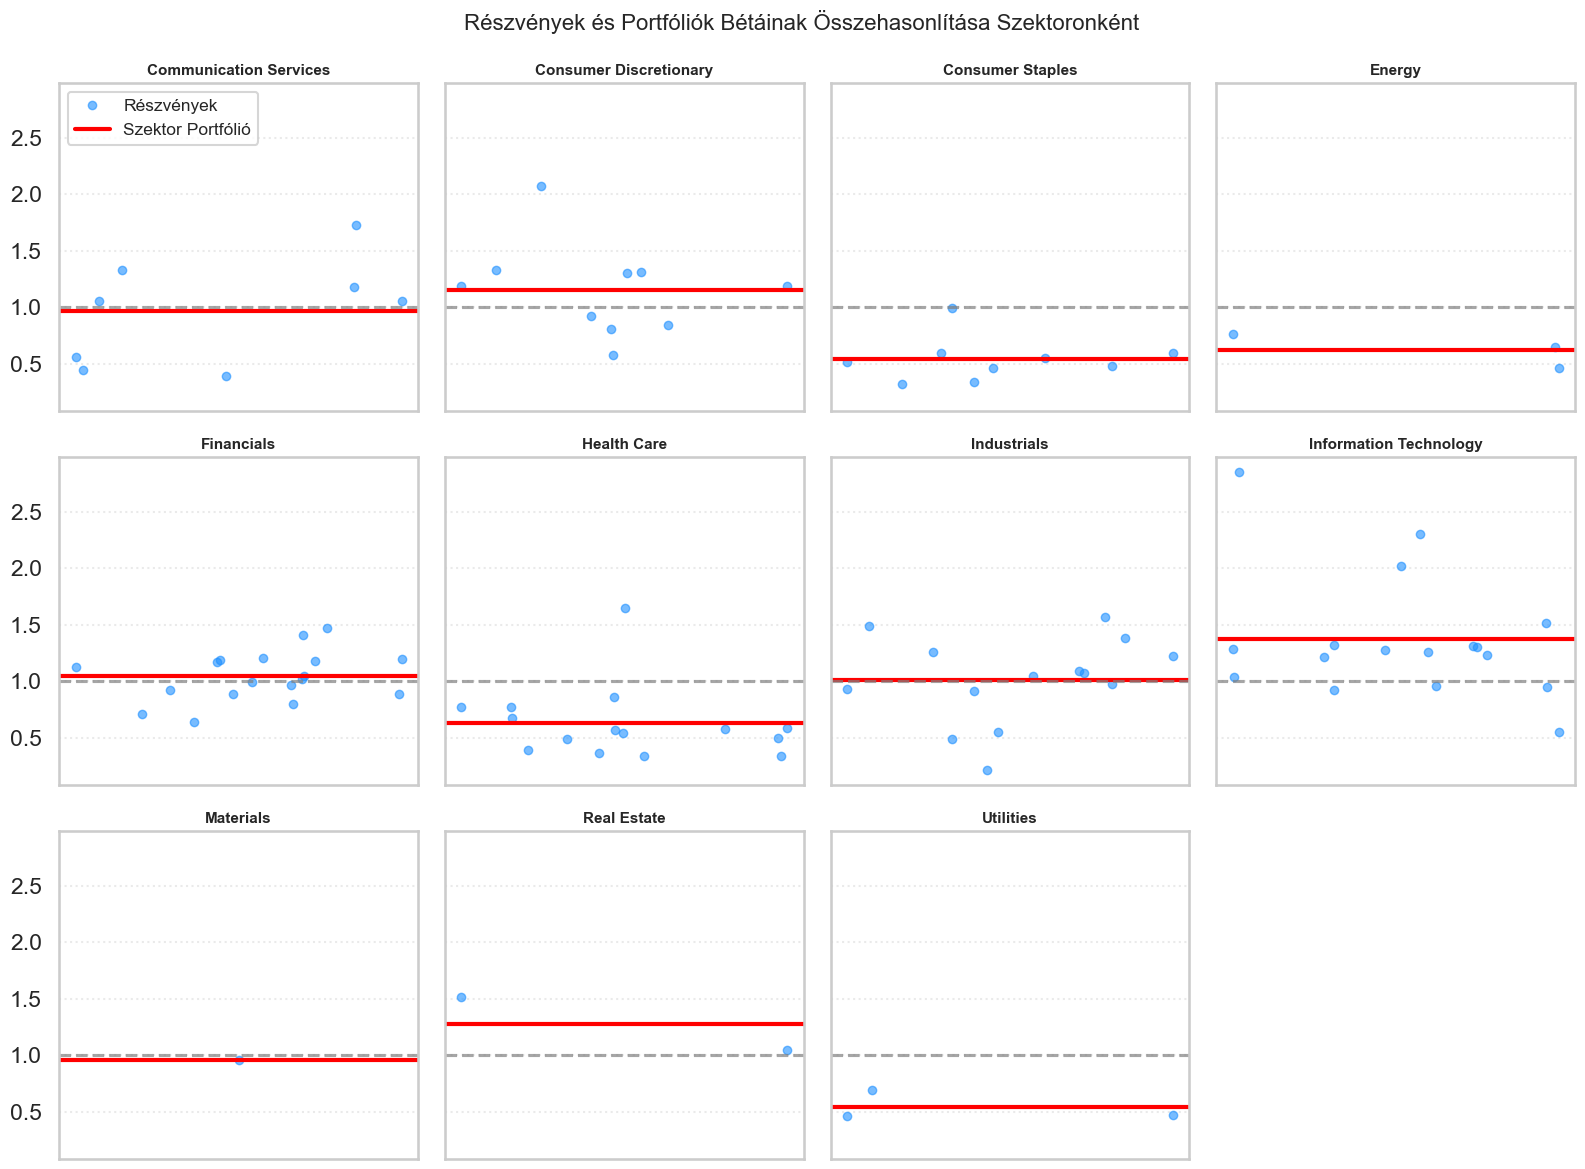

Kész!


In [57]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# --- 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE ---
print("Adatok betöltése...")
stock_returns = pd.read_csv('data_monthly_stocks.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('data_monthly_market.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('data_monthly_rf.csv', index_col=0, parse_dates=True)

# Közös időszak
common_index = stock_returns.index.intersection(market_ret.index).intersection(rf_rate.index)
stock_returns = stock_returns.loc[common_index]
market_ret = market_ret.loc[common_index]
rf_rate = rf_rate.loc[common_index]

# Többlethozamok számítása (Ri - Rf)
rf = rf_rate.iloc[:, 0].shift(1) # Rf eltolása (időszak eleje vs vége)
market_excess = market_ret.iloc[:, 0] - rf
stock_excess = stock_returns.sub(rf, axis=0)

# Érvényes adatok szűrése
valid_idx = market_excess.dropna().index.intersection(stock_excess.dropna().index)
market_excess = market_excess.loc[valid_idx]
stock_excess = stock_excess.loc[valid_idx]

# --- 2. SZEKTOR BESOROLÁS (GICS) ---
sector_map = {
    'CMCSA': 'Communication Services', 'DIS': 'Communication Services', 'GOOG': 'Communication Services',
    'META': 'Communication Services', 'NFLX': 'Communication Services', 'T': 'Communication Services',
    'TMUS': 'Communication Services', 'VZ': 'Communication Services',
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'GM': 'Consumer Discretionary',
    'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 'MCD': 'Consumer Discretionary',
    'NKE': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 'TGT': 'Consumer Discretionary',
    'TSLA': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples',
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples',
    'PG': 'Consumer Staples', 'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials',
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials',
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials',
    'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials',
    'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care',
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care',
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care',
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials',
    'FDX': 'Industrials', 'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials',
    'LMT': 'Industrials', 'MMM': 'Industrials', 'RTX': 'Industrials', 'UBER': 'Industrials',
    'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology',
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CRM': 'Information Technology',
    'CSCO': 'Information Technology', 'IBM': 'Information Technology', 'INTC': 'Information Technology',
    'INTU': 'Information Technology', 'MSFT': 'Information Technology', 'NOW': 'Information Technology',
    'NVDA': 'Information Technology', 'ORCL': 'Information Technology', 'PLTR': 'Information Technology',
    'QCOM': 'Information Technology', 'TXN': 'Information Technology',
    'LIN': 'Materials',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

# --- 3. BÉTÁK KISZÁMÍTÁSA (Regressziók) ---
print("Béták számítása folyamatban...")

# A) Egyedi Részvények
stock_betas = {} # Fontos: Ez most egy szótár (Dictionary) lesz!
X = sm.add_constant(market_excess)

for ticker in stock_excess.columns:
    y = stock_excess[ticker]
    mask = y.notna()
    if mask.sum() > 24: # Min 2 év adat
        model = sm.OLS(y[mask], X[mask]).fit()
        stock_betas[ticker] = model.params.iloc[1]

# B) Iparági Portfóliók
sector_returns = stock_returns.T.groupby(sector_map).mean().T
sector_excess = sector_returns.sub(rf, axis=0).loc[valid_idx]

sector_betas = {}
for sec in sector_excess.columns:
    y = sector_excess[sec]
    mask = y.notna()
    if mask.sum() > 24:
        model = sm.OLS(y[mask], X[mask]).fit()
        sector_betas[sec] = model.params.iloc[1]

# --- 4. VIZUALIZÁCIÓ (SUBPLOTS) ---
print("Ábra készítése...")

unique_sectors = sorted(list(set(sector_map.values())))
cols = 4  # Hány oszlop legyen az ábrán
rows = (len(unique_sectors) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, sector in enumerate(unique_sectors):
    ax = axes[i]
    
    # Kikeressük az adott szektor részvényeit
    sector_tickers = [t for t, s in sector_map.items() if s == sector]
    
    # Kikeressük a bétáikat a 'stock_betas' szótárból
    vals = [stock_betas[t] for t in sector_tickers if t in stock_betas]

    if vals:
        # Kék pontok (Részvények) - Jitter (szóródás) az x-tengelyen a láthatóságért
        x_jitter = np.random.normal(1, 0.08, size=len(vals))
        ax.plot(x_jitter, vals, 'o', color='dodgerblue', alpha=0.6, markersize=6, label='Részvények')
        
        # Piros vonal (Szektor Béta)
        if sector in sector_betas:
            sec_beta_val = sector_betas[sector]
            ax.axhline(sec_beta_val, color='red', linewidth=3, label='Szektor')
        
        # Szürke vonal (Piaci átlag)
        ax.axhline(1, color='gray', linestyle='--', alpha=0.7)
        
    ax.set_title(sector, fontsize=11, fontweight='bold')
    ax.set_xticks([]) # X tengely felirat nem kell
    ax.grid(axis='y', linestyle=':', alpha=0.4)
    
    # Csak az elsőnél tesszük ki a jelmagyarázatot
    if i == 0:
        ax.legend(['Részvények', 'Szektor Portfólió'], loc='upper left', fontsize='x-small')

# Üres panelek törlése
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Részvények és Portfóliók Bétáinak Összehasonlítása Szektoronként', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()
print("Kész!")

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE ---
print("Adatok betöltése...")
stock_ret = pd.read_csv('data_monthly_stocks.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('data_monthly_market.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('data_monthly_rf.csv', index_col=0, parse_dates=True)

# Oszlopnevek (ellenőrzés után)
mkt_col = market_ret.columns[0] # ^OEX
rf_col = rf_rate.columns[0]     # ^TNX

# Közös index és időbeli igazítás
common_idx = stock_ret.index.intersection(market_ret.index).intersection(rf_rate.index)
stock_ret = stock_ret.loc[common_idx]
# Rf eltolása (lag) és évesítés korrekció (már havi adat, de 100-zal osztás/12 kellhet, ha %-os)
# A letöltő kódodban már osztottad, feltételezzük, hogy itt tiszta tizedesjegy (0.003) vagy %
# A biztonság kedvéért feltételezzük a letöltő kód logikáját (már kész havi ráta)
rf = rf_rate.loc[common_idx, rf_col].shift(1) 
mkt = market_ret.loc[common_idx, mkt_col]

# Többlethozamok
market_excess = mkt - rf
stock_excess = stock_ret.sub(rf, axis=0)

# NaN szűrés
valid_idx = market_excess.dropna().index.intersection(stock_excess.dropna().index)
market_excess = market_excess.loc[valid_idx]
stock_excess = stock_excess.loc[valid_idx]

# --- 2. IPARÁGI PORTFÓLIÓK KÉPZÉSE ---
sector_map = {
    'CMCSA': 'Communication', 'DIS': 'Communication', 'GOOG': 'Communication', 'META': 'Communication', 
    'NFLX': 'Communication', 'T': 'Communication', 'TMUS': 'Communication', 'VZ': 'Communication',
    'AMZN': 'Cons. Discret.', 'BKNG': 'Cons. Discret.', 'GM': 'Cons. Discret.', 'HD': 'Cons. Discret.', 
    'LOW': 'Cons. Discret.', 'MCD': 'Cons. Discret.', 'NKE': 'Cons. Discret.', 'SBUX': 'Cons. Discret.', 
    'TGT': 'Cons. Discret.', 'TSLA': 'Cons. Discret.',
    'CL': 'Cons. Staples', 'COST': 'Cons. Staples', 'KO': 'Cons. Staples', 'MDLZ': 'Cons. Staples', 
    'MO': 'Cons. Staples', 'PEP': 'Cons. Staples', 'PG': 'Cons. Staples', 'PM': 'Cons. Staples', 'WMT': 'Cons. Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 'BLK': 'Financials', 
    'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 'GS': 'Financials', 'JPM': 'Financials', 
    'MA': 'Financials', 'MET': 'Financials', 'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 
    'USB': 'Financials', 'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 'CVS': 'Health Care', 
    'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 'JNJ': 'Health Care', 'LLY': 'Health Care', 
    'MDT': 'Health Care', 'MRK': 'Health Care', 'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 'FDX': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'LMT': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UBER': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Info Tech', 'ACN': 'Info Tech', 'ADBE': 'Info Tech', 'AMD': 'Info Tech', 'AVGO': 'Info Tech', 
    'CRM': 'Info Tech', 'CSCO': 'Info Tech', 'IBM': 'Info Tech', 'INTC': 'Info Tech', 'INTU': 'Info Tech', 
    'MSFT': 'Info Tech', 'NOW': 'Info Tech', 'NVDA': 'Info Tech', 'ORCL': 'Info Tech', 'PLTR': 'Info Tech', 
    'QCOM': 'Info Tech', 'TXN': 'Info Tech',
    'LIN': 'Materials', 'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}
sector_returns = stock_ret.T.groupby(sector_map).mean().T
sector_excess = sector_returns.sub(rf, axis=0).loc[valid_idx]

# --- 3. FIRST PASS FÜGGVÉNY ---
def excel_first_pass(assets_excess, mkt_excess):
    """
    Kiszámolja minden eszközre a Bétát, Alfát és a maradék kockázatot (Sigma^2).
    """
    rows = []
    var_m = np.var(mkt_excess, ddof=1)
    
    for s in assets_excess.columns:
        Ri = assets_excess[s]
        
        # Adatszűrés (hiányzó adatok)
        mask = Ri.notna() & mkt_excess.notna()
        if mask.sum() < 24: continue # Min 2 év adat kell
        
        Ri_clean = Ri[mask]
        Rm_clean = mkt_excess[mask]
        
        # Kovariancia és Béta
        cov = np.cov(Ri_clean, Rm_clean)[0, 1]
        beta = cov / var_m
        
        # Alfa
        alpha = Ri_clean.mean() - beta * Rm_clean.mean()
        
        # Egyedi kockázat (Sigma^2) - A te képleted szerint
        # sigma2 = var(Ri - beta*Rm)
        resid = Ri_clean - beta * Rm_clean
        sigma2 = np.var(resid, ddof=1)
        
        rows.append({
            'Ticker': s,
            'beta': beta,
            'sigma2': sigma2,
            'riskprem_mean': Ri_clean.mean()
        })
        
    return pd.DataFrame(rows)

# --- 4. SECOND PASS FÜGGVÉNY (A TE KÓDOD ALAPJÁN) ---
def user_second_pass(first_pass_df, label):
    # Data frame (Index beállítása)
    valid = first_pass_df.set_index('Ticker')
    
    # Célváltozó
    y = valid['riskprem_mean']
    
    # --- MODEL 1: Csak Beta (Standard CAPM) ---
    X1 = sm.add_constant(valid[['beta']])
    model1 = sm.OLS(y, X1).fit()
    
    # --- MODEL 2: Beta + Sigma2 (Kiterjesztett) ---
    X2 = sm.add_constant(valid[['beta', 'sigma2']])
    model2 = sm.OLS(y, X2).fit()
    
    return {
        'Típus': label,
        # Model 1 Eredmények
        'Gamma0 (Intercept)': model1.params['const'],
        'p(g0)': model1.pvalues['const'],
        'Gamma1 (Beta Slope)': model1.params['beta'],
        'p(g1)': model1.pvalues['beta'],
        'Adj. R2 (M1)': model1.rsquared_adj,
        
        # Model 2 Eredmények (Sigma2 teszt)
        'Gamma_Sigma2': model2.params['sigma2'],
        'p(g_sigma2)': model2.pvalues['sigma2'],
        'Adj. R2 (M2)': model2.rsquared_adj
    }

# --- 5. ELEMZÉS FUTTATÁSA ÉS STABILITÁS VIZSGÁLAT ---
print("\nRegressziók futtatása...")
results_summary = []

# Két fő periódus a stabilitás vizsgálatához
periods = [
    ('Teljes (2000-2025)', '2000-01-01', '2025-11-01'), # <- ÚJ SOR
    ('2000-2012', '2000-01-01', '2012-12-31'),
    ('2013-2025', '2013-01-01', '2025-11-01')
]

for per_name, start, end in periods:
    # Adatok vágása
    sub_mkt = market_excess.loc[start:end]
    sub_stocks = stock_excess.loc[start:end]
    sub_sectors = sector_excess.loc[start:end]
    
    if len(sub_mkt) < 24: continue

    # --- A) EGYEDI RÉSZVÉNYEK ---
    fp_stocks = excel_first_pass(sub_stocks, sub_mkt)
    res_stocks = user_second_pass(fp_stocks, f"Részvények ({per_name})")
    results_summary.append(res_stocks)
    
    # --- B) IPARÁGI PORTFÓLIÓK ---
    fp_sectors = excel_first_pass(sub_sectors, sub_mkt)
    res_sectors = user_second_pass(fp_sectors, f"Portfóliók ({per_name})")
    results_summary.append(res_sectors)

# --- 6. EREDMÉNYEK KIÍRATÁSA ---
df_res = pd.DataFrame(results_summary).set_index('Típus')

print("\n=== STABILITÁS ÉS PORFÓLIÓ HATÁS VIZSGÁLATA ===")
print("Model 1: Ri = g0 + g1*Beta")
print("Model 2: Ri = g0 + g1*Beta + g2*Sigma^2")
print("-" * 80)
# Formázás, hogy olvashatóbb legyen
display_cols = ['Gamma0 (Intercept)', 'p(g0)', 'Gamma1 (Beta Slope)', 'p(g1)', 'Gamma_Sigma2', 'p(g_sigma2)', 'Adj. R2 (M1)']
print(df_res[display_cols].round(4))

print("\n--- ÉRTELMEZÉS (A Feladathoz) ---")
print("1. STABILITÁS: Nézd meg, hogyan változik a 'Gamma1 (Beta Slope)' a két időszak között!")
print("   - Ha nagy az ugrás (pl. pozitívból negatívba), a CAPM instabil.")
print("   - A Portfólióknál (páros sorok) általában kisebb az ingadozás, mint az egyedi részvényeknél?")
print("2. MODEL 1 (SML): Szignifikáns a Beta? (p(g1) < 0.05). Pozitív a meredekség?")
print("3. MODEL 2 (Sigma2): Szignifikáns a 'Gamma_Sigma2'? (p(g_sigma2) < 0.05).")
print("   - A CAPM szerint NEM szabadna annak lennie (csak a Beta számít).")
print("   - Ha szignifikáns, akkor az 'egyedi kockázat beárazódott', ami ellentmond a modellnek.")

Adatok betöltése...

Regressziók futtatása...

=== STABILITÁS ÉS PORFÓLIÓ HATÁS VIZSGÁLATA ===
Model 1: Ri = g0 + g1*Beta
Model 2: Ri = g0 + g1*Beta + g2*Sigma^2
--------------------------------------------------------------------------------
                                 Gamma0 (Intercept)   p(g0)  \
Típus                                                         
Részvények (Teljes (2000-2025))              0.0021  0.4470   
Portfóliók (Teljes (2000-2025))              0.0127  0.1267   
Részvények (2013-2025)                       0.0021  0.4470   
Portfóliók (2013-2025)                       0.0127  0.1267   

                                 Gamma1 (Beta Slope)   p(g1)  Gamma_Sigma2  \
Típus                                                                        
Részvények (Teljes (2000-2025))               0.0106  0.0001        0.4029   
Portfóliók (Teljes (2000-2025))               0.0003  0.9663        3.6434   
Részvények (2013-2025)                        0.0106  0.0001      

Jensen's Alpha Eredmények (Mérési hibák):

--- 2000-2012 (Válságos időszak) ---
        Sector  Alpha (%)  P-value   Beta
   Real Estate     1.9008   0.0123 1.0783
Cons. Discret.     1.4889   0.0001 1.1614
     Materials     1.3738   0.0012 0.8284
     Info Tech     1.3235   0.0019 1.5014
   Industrials     1.0087   0.0005 0.9578
        Energy     0.9955   0.0113 0.7163
   Health Care     0.9722   0.0000 0.6541
 Communication     0.9641   0.0070 0.8962
    Financials     0.9470   0.0059 1.3159
     Utilities     0.8395   0.0259 0.2979
 Cons. Staples     0.7349   0.0054 0.4678

--- 2013-2025 (Bikapiac) ---
        Sector  Alpha (%)  P-value   Beta
     Info Tech     0.9096   0.0002 1.2497
 Communication     0.6546   0.0134 0.9016
Cons. Discret.     0.6004   0.0187 1.1269
     Utilities     0.5698   0.1543 0.3794
   Health Care     0.5225   0.0251 0.7019
     Materials     0.3482   0.3084 0.8670
 Cons. Staples     0.2912   0.2241 0.6119
    Financials     0.1037   0.7445 1.1442
   Indus

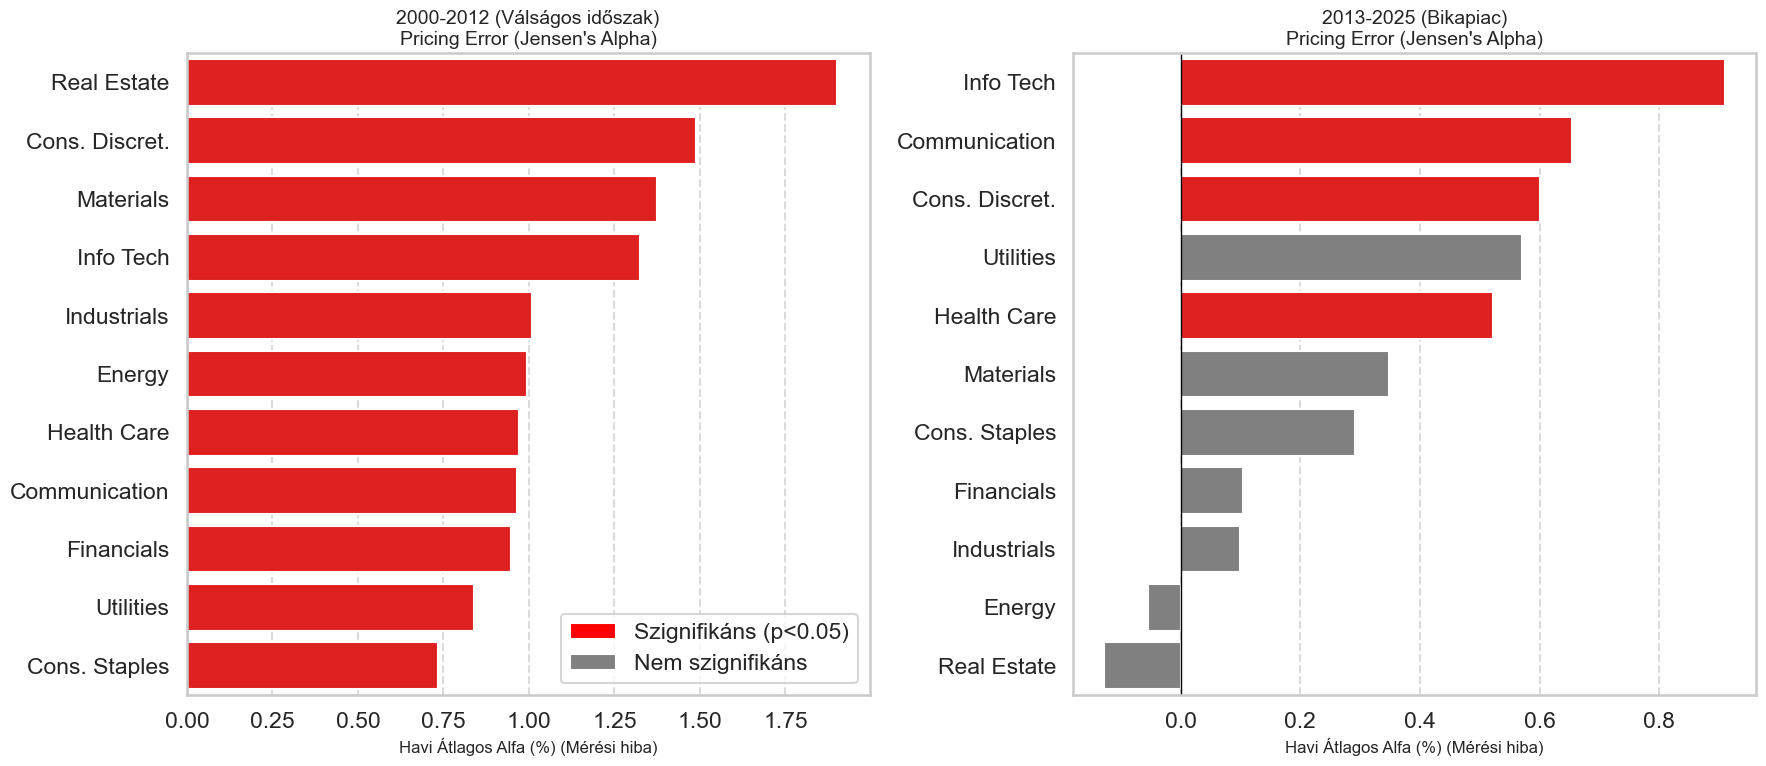

In [59]:
# 1. ADATOK BETÖLTÉSE
stock_ret = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# 2. ELŐKÉSZÍTÉS
mkt_col = market_ret.columns[0]
rf_col = rf_rate.columns[0]

# Közös index
common_idx = stock_ret.index.intersection(market_ret.index).intersection(rf_rate.index)
stock_ret = stock_ret.loc[common_idx]
mkt = market_ret.loc[common_idx, mkt_col]
# Rf shift (ahogy a korábbi kódokban)
rf = rf_rate.loc[common_idx, rf_col].shift(1)

# Többlethozamok
market_excess = (mkt - rf).dropna()
# A stock_ret indexét is igazítjuk a market_excess-hez (mert a shift miatt az első adat kiesik)
valid_idx = market_excess.index.intersection(stock_ret.index)
market_excess = market_excess.loc[valid_idx]
stock_excess = stock_ret.loc[valid_idx].sub(rf.loc[valid_idx], axis=0)

# 3. IPARÁGI PORTFÓLIÓK
sector_map = {
    'CMCSA': 'Communication', 'DIS': 'Communication', 'GOOG': 'Communication', 'META': 'Communication', 
    'NFLX': 'Communication', 'T': 'Communication', 'TMUS': 'Communication', 'VZ': 'Communication',
    'AMZN': 'Cons. Discret.', 'BKNG': 'Cons. Discret.', 'GM': 'Cons. Discret.', 'HD': 'Cons. Discret.', 
    'LOW': 'Cons. Discret.', 'MCD': 'Cons. Discret.', 'NKE': 'Cons. Discret.', 'SBUX': 'Cons. Discret.', 
    'TGT': 'Cons. Discret.', 'TSLA': 'Cons. Discret.',
    'CL': 'Cons. Staples', 'COST': 'Cons. Staples', 'KO': 'Cons. Staples', 'MDLZ': 'Cons. Staples', 
    'MO': 'Cons. Staples', 'PEP': 'Cons. Staples', 'PG': 'Cons. Staples', 'PM': 'Cons. Staples', 'WMT': 'Cons. Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 'BLK': 'Financials', 
    'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 'GS': 'Financials', 'JPM': 'Financials', 
    'MA': 'Financials', 'MET': 'Financials', 'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 
    'USB': 'Financials', 'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 'CVS': 'Health Care', 
    'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 'JNJ': 'Health Care', 'LLY': 'Health Care', 
    'MDT': 'Health Care', 'MRK': 'Health Care', 'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 'FDX': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'LMT': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UBER': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Info Tech', 'ACN': 'Info Tech', 'ADBE': 'Info Tech', 'AMD': 'Info Tech', 'AVGO': 'Info Tech', 
    'CRM': 'Info Tech', 'CSCO': 'Info Tech', 'IBM': 'Info Tech', 'INTC': 'Info Tech', 'INTU': 'Info Tech', 
    'MSFT': 'Info Tech', 'NOW': 'Info Tech', 'NVDA': 'Info Tech', 'ORCL': 'Info Tech', 'PLTR': 'Info Tech', 
    'QCOM': 'Info Tech', 'TXN': 'Info Tech',
    'LIN': 'Materials', 'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

cols_in_map = [c for c in stock_excess.columns if c in sector_map]
sector_returns = stock_ret[cols_in_map].T.groupby(sector_map).mean().T
sector_excess = sector_returns.sub(rf.loc[valid_idx], axis=0).dropna()

# 4. JENSEN'S ALPHA SZÁMÍTÁSA (MÉRÉSI HIBA)
def calculate_alphas(assets_excess, mkt_excess):
    results = []
    X = sm.add_constant(mkt_excess)
    
    for sector in assets_excess.columns:
        y = assets_excess[sector]
        # Illesztés
        model = sm.OLS(y, X).fit()
        
        alpha = model.params['const']
        alpha_pval = model.pvalues['const']
        beta = model.params[mkt_excess.name] # vagy az oszlopnév
        
        results.append({
            'Sector': sector,
            'Alpha': alpha,
            'Alpha (%)': alpha * 100, # Százalékos formátum
            'P-value': alpha_pval,
            'Significant': alpha_pval < 0.05,
            'Beta': beta
        })
    
    return pd.DataFrame(results).sort_values('Alpha (%)', ascending=False)

# 5. ELEMZÉS KÉT IDŐSZAKRA
periods = [
    ('2000-2012 (Válságos időszak)', '2000-01-01', '2012-12-31'),
    ('2013-2025 (Bikapiac)', '2013-01-01', '2025-11-01')
]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for i, (name, start, end) in enumerate(periods):
    # Adatok vágása
    sub_mkt = market_excess.loc[start:end]
    sub_sec = sector_excess.loc[start:end]
    
    # Név átadása a seriesnek a regresszióhoz
    sub_mkt.name = 'Market'
    
    if len(sub_mkt) < 24: continue
    
    df_res = calculate_alphas(sub_sec, sub_mkt)
    
    # Ábrázolás
    ax = axes[i]
    # Színkód: Ha szignifikáns (p<0.05), akkor sötétebb/élénkebb szín
    colors = ['red' if sig else 'grey' for sig in df_res['Significant']]
    
    sns.barplot(data=df_res, x='Alpha (%)', y='Sector', ax=ax, palette=colors, orient='h')
    
    ax.set_title(f"{name}\nPricing Error (Jensen's Alpha)", fontsize=14)
    ax.set_xlabel('Havi Átlagos Alfa (%) (Mérési hiba)', fontsize=12)
    ax.set_ylabel('')
    ax.axvline(0, color='black', linewidth=1)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Jelmagyarázat (csak az elsőhöz)
    if i == 0:
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', label='Szignifikáns (p<0.05)'),
                           Patch(facecolor='grey', label='Nem szignifikáns')]
        ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('capm_sector_alphas.png', dpi=150)

# Eredmények kiíratása táblázatosan is a felhasználónak
print("Jensen's Alpha Eredmények (Mérési hibák):")
for name, start, end in periods:
    sub_mkt = market_excess.loc[start:end]
    sub_sec = sector_excess.loc[start:end]
    sub_mkt.name = 'Market'
    if len(sub_mkt) > 24:
        df = calculate_alphas(sub_sec, sub_mkt)
        print(f"\n--- {name} ---")
        print(df[['Sector', 'Alpha (%)', 'P-value', 'Beta']].round(4).to_string(index=False))

Calculating Rolling Gammas for Stocks...
Calculating Rolling Gammas for Portfolios...

Béták Átlagos Szórása (Dispersion of Betas):
Részvények: 0.4955
Portfóliók: 0.3267
(A kisebb szórás a portfólióknál azt jelenti, hogy 'összébb húzódtak' az értékek, ami csökkentheti a becslés hatékonyságát, de a mérési hibát is.)


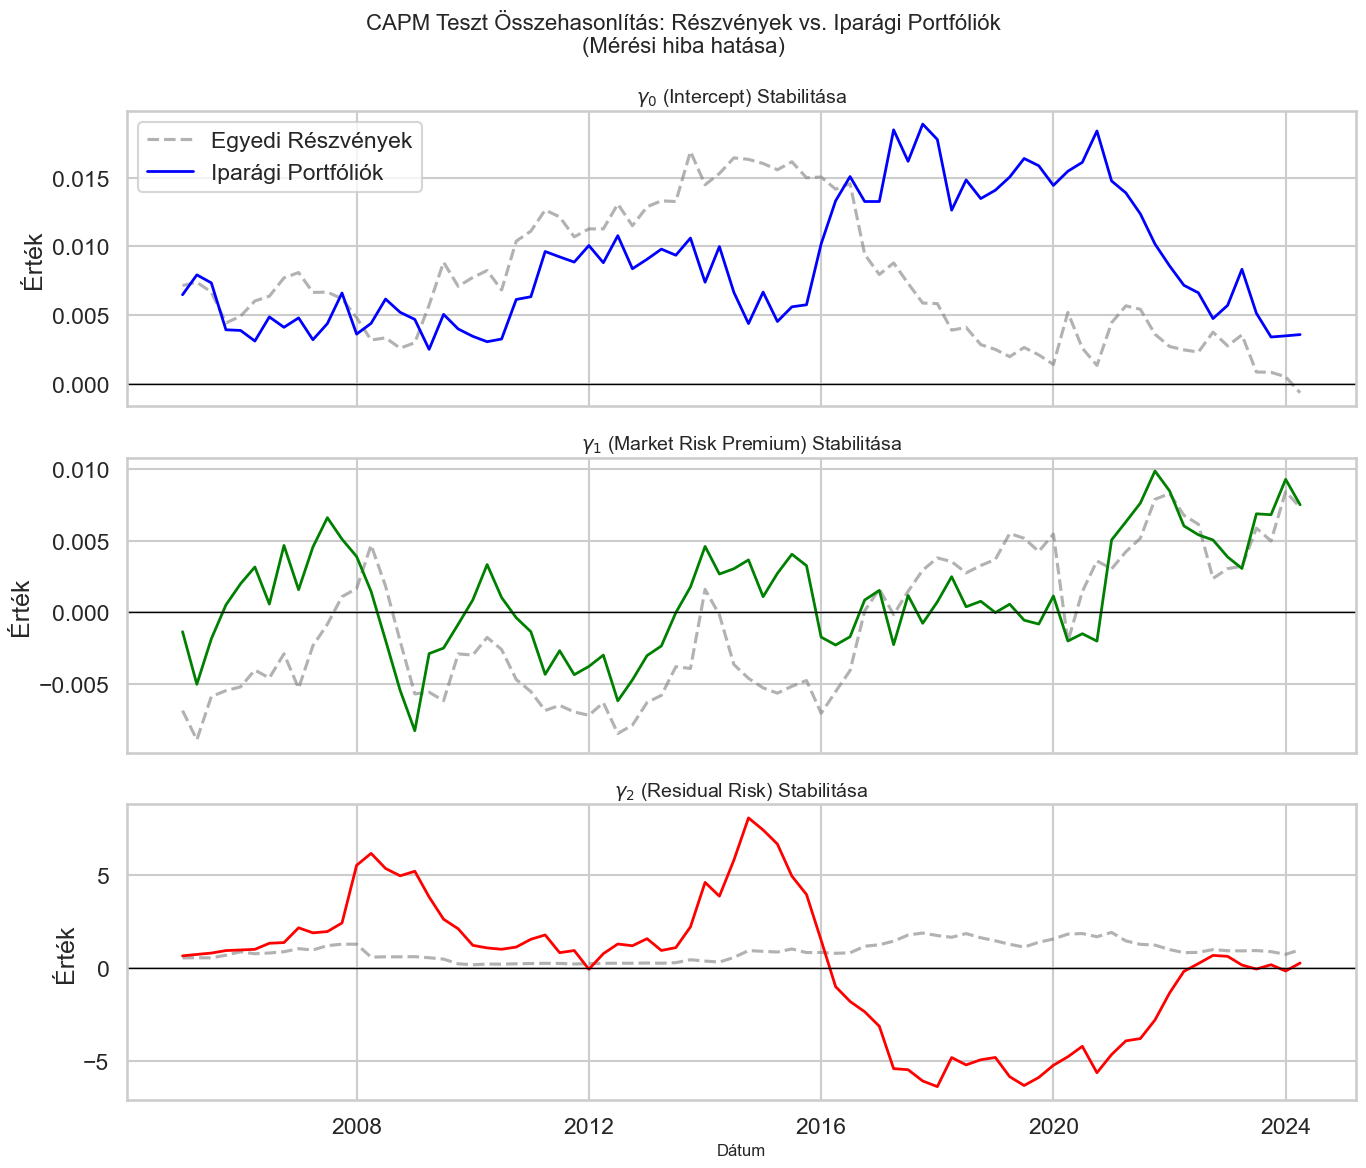

In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ADATOK BETÖLTÉSE
stock_ret = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# 2. ELŐKÉSZÍTÉS
mkt_col = market_ret.columns[0]
rf_col = rf_rate.columns[0]
common_idx = stock_ret.index.intersection(market_ret.index).intersection(rf_rate.index)
stock_ret = stock_ret.loc[common_idx]
mkt = market_ret.loc[common_idx, mkt_col]
rf = rf_rate.loc[common_idx, rf_col].shift(1)

# Többlethozamok
market_excess = (mkt - rf).dropna()
valid_idx = market_excess.index.intersection(stock_ret.index)
market_excess = market_excess.loc[valid_idx]
stock_excess = stock_ret.loc[valid_idx].sub(rf.loc[valid_idx], axis=0)

# 3. IPARÁGI PORTFÓLIÓK LÉTREHOZÁSA (Equal Weighted)
sector_map = {
    'CMCSA': 'Communication', 'DIS': 'Communication', 'GOOG': 'Communication', 'META': 'Communication', 
    'NFLX': 'Communication', 'T': 'Communication', 'TMUS': 'Communication', 'VZ': 'Communication',
    'AMZN': 'Cons. Discret.', 'BKNG': 'Cons. Discret.', 'GM': 'Cons. Discret.', 'HD': 'Cons. Discret.', 
    'LOW': 'Cons. Discret.', 'MCD': 'Cons. Discret.', 'NKE': 'Cons. Discret.', 'SBUX': 'Cons. Discret.', 
    'TGT': 'Cons. Discret.', 'TSLA': 'Cons. Discret.',
    'CL': 'Cons. Staples', 'COST': 'Cons. Staples', 'KO': 'Cons. Staples', 'MDLZ': 'Cons. Staples', 
    'MO': 'Cons. Staples', 'PEP': 'Cons. Staples', 'PG': 'Cons. Staples', 'PM': 'Cons. Staples', 'WMT': 'Cons. Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 'BLK': 'Financials', 
    'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 'GS': 'Financials', 'JPM': 'Financials', 
    'MA': 'Financials', 'MET': 'Financials', 'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 
    'USB': 'Financials', 'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 'CVS': 'Health Care', 
    'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 'JNJ': 'Health Care', 'LLY': 'Health Care', 
    'MDT': 'Health Care', 'MRK': 'Health Care', 'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 'FDX': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'LMT': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UBER': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Info Tech', 'ACN': 'Info Tech', 'ADBE': 'Info Tech', 'AMD': 'Info Tech', 'AVGO': 'Info Tech', 
    'CRM': 'Info Tech', 'CSCO': 'Info Tech', 'IBM': 'Info Tech', 'INTC': 'Info Tech', 'INTU': 'Info Tech', 
    'MSFT': 'Info Tech', 'NOW': 'Info Tech', 'NVDA': 'Info Tech', 'ORCL': 'Info Tech', 'PLTR': 'Info Tech', 
    'QCOM': 'Info Tech', 'TXN': 'Info Tech',
    'LIN': 'Materials', 'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

# Szűrés a meglévő oszlopokra
cols_in_map = [c for c in stock_excess.columns if c in sector_map]
# Groupby mean -> Portfólió hozamok
sector_returns_df = stock_ret[cols_in_map].T.groupby(sector_map).mean().T
sector_excess = sector_returns_df.sub(rf.loc[valid_idx], axis=0).dropna()
# Align index
sector_excess = sector_excess.loc[market_excess.index]

# 4. ROLLING REGRESSZIÓ FÜGGVÉNY (Újrafelhasználva)
def rolling_fama_macbeth(assets_data, market_data, window=60, step=6):
    results = []
    
    # Iterálás az ablakokon
    for i in range(0, len(market_data) - window + 1, step):
        curr_mkt = market_data.iloc[i : i + window]
        curr_assets = assets_data.iloc[i : i + window]
        date_label = curr_mkt.index[-1]
        
        # --- FIRST PASS (Beták) ---
        var_m = np.var(curr_mkt, ddof=1)
        betas = []
        sigmas = []
        means = []
        
        for ticker in curr_assets.columns:
            Ri = curr_assets[ticker]
            # Adatszűrés (min 80% kitöltöttség az ablakban)
            mask = Ri.notna() & curr_mkt.notna()
            if mask.sum() < window * 0.8: continue
            
            Ri_clean = Ri[mask]
            Rm_clean = curr_mkt[mask]
            
            # Beta
            cov = np.cov(Ri_clean, Rm_clean)[0, 1]
            beta = cov / var_m
            
            # Sigma2 (Residual)
            model_ts = sm.OLS(Ri_clean, sm.add_constant(Rm_clean)).fit()
            sigma2 = model_ts.mse_resid
            
            betas.append(beta)
            sigmas.append(sigma2)
            means.append(Ri_clean.mean())
        
        if len(betas) < 5: continue # Ha túl kevés asset van (pl portfólióknál)
            
        # --- SECOND PASS (Gamma becslés) ---
        # Model: E[R] = g0 + g1*Beta + g2*Sigma2
        df_xs = pd.DataFrame({'mean_ret': means, 'beta': betas, 'sigma2': sigmas})
        
        try:
            model_xs = sm.OLS(df_xs['mean_ret'], sm.add_constant(df_xs[['beta', 'sigma2']])).fit()
            
            results.append({
                'Date': date_label,
                'Gamma0': model_xs.params['const'],
                'Gamma1': model_xs.params['beta'],
                'Gamma2': model_xs.params['sigma2'],
                'Beta_Std': np.std(betas) # Béták szórása (hogy lássuk a csökkenést)
            })
        except:
            continue
            
    return pd.DataFrame(results)

# 5. ELEMZÉS FUTTATÁSA
print("Calculating Rolling Gammas for Stocks...")
df_roll_stocks = rolling_fama_macbeth(stock_excess, market_excess, window=60, step=3)

print("Calculating Rolling Gammas for Portfolios...")
df_roll_sectors = rolling_fama_macbeth(sector_excess, market_excess, window=60, step=3)

# 6. ÖSSZEHASONLÍTÓ ÁBRA
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Gamma 0
ax = axes[0]
ax.plot(df_roll_stocks['Date'], df_roll_stocks['Gamma0'], color='grey', alpha=0.6, label='Egyedi Részvények', linestyle='--')
ax.plot(df_roll_sectors['Date'], df_roll_sectors['Gamma0'], color='blue', linewidth=2, label='Iparági Portfóliók')
ax.axhline(0, color='black', linewidth=1)
ax.set_title(r'$\gamma_0$ (Intercept) Stabilitása', fontsize=14)
ax.legend()
ax.set_ylabel('Érték')

# Gamma 1 (Risk Premium)
ax = axes[1]
ax.plot(df_roll_stocks['Date'], df_roll_stocks['Gamma1'], color='grey', alpha=0.6, linestyle='--', label='Egyedi Részvények')
ax.plot(df_roll_sectors['Date'], df_roll_sectors['Gamma1'], color='green', linewidth=2, label='Iparági Portfóliók')
ax.axhline(0, color='black', linewidth=1)
ax.set_title(r'$\gamma_1$ (Market Risk Premium) Stabilitása', fontsize=14)
ax.set_ylabel('Érték')

# Gamma 2 (Residual Risk)
ax = axes[2]
ax.plot(df_roll_stocks['Date'], df_roll_stocks['Gamma2'], color='grey', alpha=0.6, linestyle='--', label='Egyedi Részvények')
ax.plot(df_roll_sectors['Date'], df_roll_sectors['Gamma2'], color='red', linewidth=2, label='Iparági Portfóliók')
ax.axhline(0, color='black', linewidth=1)
ax.set_title(r'$\gamma_2$ (Residual Risk) Stabilitása', fontsize=14)
ax.set_ylabel('Érték')

plt.xlabel('Dátum', fontsize=12)
plt.suptitle('CAPM Teszt Összehasonlítás: Részvények vs. Iparági Portfóliók\n(Mérési hiba hatása)', fontsize=16)
plt.tight_layout()
plt.savefig('capm_comparison_stability.png', dpi=150)

# Eredmények statisztikái
print("\nBéták Átlagos Szórása (Dispersion of Betas):")
print(f"Részvények: {df_roll_stocks['Beta_Std'].mean():.4f}")
print(f"Portfóliók: {df_roll_sectors['Beta_Std'].mean():.4f}")
print("(A kisebb szórás a portfólióknál azt jelenti, hogy 'összébb húzódtak' az értékek, ami csökkentheti a becslés hatékonyságát, de a mérési hibát is.)")

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 1. ADATOK BETÖLTÉSE
stock_ret = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# 2. ELŐKÉSZÍTÉS
mkt_col = market_ret.columns[0]
rf_col = rf_rate.columns[0]
common_idx = stock_ret.index.intersection(market_ret.index).intersection(rf_rate.index)
stock_ret = stock_ret.loc[common_idx]
mkt = market_ret.loc[common_idx, mkt_col]
rf = rf_rate.loc[common_idx, rf_col].shift(1)

market_excess = (mkt - rf).dropna()
valid_idx = market_excess.index.intersection(stock_ret.index)
market_excess = market_excess.loc[valid_idx]
stock_excess = stock_ret.loc[valid_idx].sub(rf.loc[valid_idx], axis=0)

# 3. IPARÁGI PORTFÓLIÓK
sector_map = {
    'CMCSA': 'Communication', 'DIS': 'Communication', 'GOOG': 'Communication', 'META': 'Communication', 
    'NFLX': 'Communication', 'T': 'Communication', 'TMUS': 'Communication', 'VZ': 'Communication',
    'AMZN': 'Cons. Discret.', 'BKNG': 'Cons. Discret.', 'GM': 'Cons. Discret.', 'HD': 'Cons. Discret.', 
    'LOW': 'Cons. Discret.', 'MCD': 'Cons. Discret.', 'NKE': 'Cons. Discret.', 'SBUX': 'Cons. Discret.', 
    'TGT': 'Cons. Discret.', 'TSLA': 'Cons. Discret.',
    'CL': 'Cons. Staples', 'COST': 'Cons. Staples', 'KO': 'Cons. Staples', 'MDLZ': 'Cons. Staples', 
    'MO': 'Cons. Staples', 'PEP': 'Cons. Staples', 'PG': 'Cons. Staples', 'PM': 'Cons. Staples', 'WMT': 'Cons. Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 'BLK': 'Financials', 
    'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 'GS': 'Financials', 'JPM': 'Financials', 
    'MA': 'Financials', 'MET': 'Financials', 'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 
    'USB': 'Financials', 'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 'CVS': 'Health Care', 
    'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 'JNJ': 'Health Care', 'LLY': 'Health Care', 
    'MDT': 'Health Care', 'MRK': 'Health Care', 'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 'FDX': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'LMT': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UBER': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Info Tech', 'ACN': 'Info Tech', 'ADBE': 'Info Tech', 'AMD': 'Info Tech', 'AVGO': 'Info Tech', 
    'CRM': 'Info Tech', 'CSCO': 'Info Tech', 'IBM': 'Info Tech', 'INTC': 'Info Tech', 'INTU': 'Info Tech', 
    'MSFT': 'Info Tech', 'NOW': 'Info Tech', 'NVDA': 'Info Tech', 'ORCL': 'Info Tech', 'PLTR': 'Info Tech', 
    'QCOM': 'Info Tech', 'TXN': 'Info Tech',
    'LIN': 'Materials', 'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

cols_in_map = [c for c in stock_excess.columns if c in sector_map]
sector_returns = stock_ret[cols_in_map].T.groupby(sector_map).mean().T
sector_excess = sector_returns.sub(rf.loc[valid_idx], axis=0).dropna()

# 4. ROLLING BETA SZÁMÍTÁSA (PORTFÓLIÓNKÉNT)
def calculate_rolling_betas(assets_excess, mkt_excess, window=60):
    rolling_betas = {}
    
    for col in assets_excess.columns:
        # Minden eszközre/portfólióra külön kiszámoljuk a rolling betát
        # Ezzel kapunk egy idősort az adott portfólió bétájáról
        
        # Helper a rolling covariance/variance-hoz
        # Sajnos a rolling().cov() kicsit bonyolultabb pandasban series-ekkel, 
        # egyszerűbb egy loop vagy a rolling apply. A loop tisztább most.
        betas = []
        dates = []
        
        for i in range(len(mkt_excess) - window + 1):
            y = assets_excess[col].iloc[i : i+window]
            x = mkt_excess.iloc[i : i+window]
            
            if len(y.dropna()) < window*0.8: 
                betas.append(np.nan)
            else:
                cov = np.cov(y, x)[0, 1]
                var = np.var(x, ddof=1)
                betas.append(cov / var)
            
            dates.append(mkt_excess.index[i+window-1])
            
        rolling_betas[col] = pd.Series(betas, index=dates)
        
    return pd.DataFrame(rolling_betas)

print("Rolling Beta számítása portfóliókra...")
df_sector_betas = calculate_rolling_betas(sector_excess, market_excess)

# Stocks (csak egy minta, különben túl sok vonal lenne)
print("Rolling Beta számítása részvényekre (minta)...")
sample_stocks = list(stock_excess.columns[:10]) + ['AAPL', 'MSFT', 'XOM', 'JPM'] # Random selection
df_stock_betas = calculate_rolling_betas(stock_excess[sample_stocks], market_excess)


# 5. ÁBRÁZOLÁS
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True, sharey=True)

# Panel A: Részvények (Minta)
ax = axes[0]
for col in df_stock_betas.columns:
    ax.plot(df_stock_betas.index, df_stock_betas[col], alpha=0.4, linewidth=1.5)
ax.set_title('A) Egyedi Részvények Bétáinak Stabilitása (Minta)', fontsize=14)
ax.set_ylabel('Béta')
ax.grid(True, linestyle=':', alpha=0.6)
ax.axhline(1, color='black', linestyle='--')

# Panel B: Portfóliók
ax = axes[1]
# Használjunk distinct színeket
palette = sns.color_palette("tab20", len(df_sector_betas.columns))
for i, col in enumerate(df_sector_betas.columns):
    ax.plot(df_sector_betas.index, df_sector_betas[col], label=col, color=palette[i], linewidth=2.5)

ax.set_title('B) Iparági Portfóliók Bétáinak Stabilitása ("Portfóliónként")', fontsize=14)
ax.set_xlabel('Idő')
ax.set_ylabel('Béta')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
ax.grid(True, linestyle=':', alpha=0.6)
ax.axhline(1, color='black', linestyle='--')

plt.tight_layout()
plt.savefig('beta_stability_comparison.png', dpi=150)

# Statisztika kiíratása
print("\nÁtlagos Időbeli Szórás (Time-Series Stability):")
print(f"Részvények (Minta) átlagos béta-ingadozása (StdDev): {df_stock_betas.std().mean():.4f}")
print(f"Portfóliók átlagos béta-ingadozása (StdDev): {df_sector_betas.std().mean():.4f}")
print("(A kisebb szám stabilabb kockázatot jelent.)")

Rolling Beta számítása portfóliókra...
Rolling Beta számítása részvényekre (minta)...


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 60

Számítás futtatása...
Utolsó becslések (Portfóliók alapján):
         Date  Gamma0  Gamma1  Gamma2
73 2023-04-01  0.0083  0.0031  0.1456
74 2023-07-01  0.0051  0.0069 -0.0764
75 2023-10-01  0.0034  0.0068  0.1626
76 2024-01-01  0.0035  0.0093 -0.1802
77 2024-04-01  0.0036  0.0075  0.2546


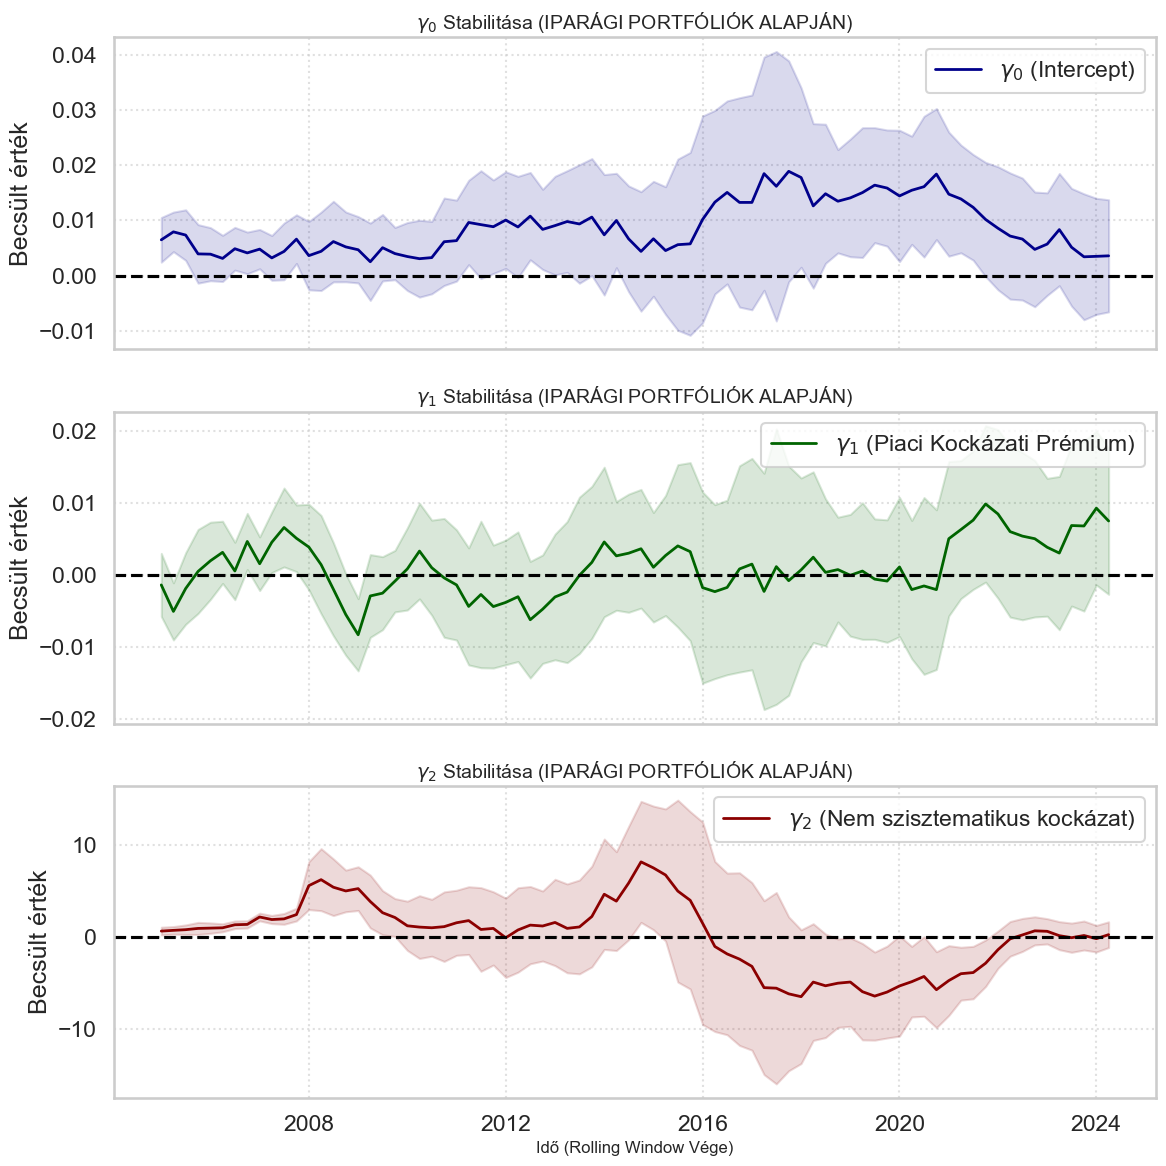

In [62]:
# 1. ADATOK BETÖLTÉSE
stock_ret = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# 2. ELŐKÉSZÍTÉS
mkt_col = market_ret.columns[0]
rf_col = rf_rate.columns[0]
common_idx = stock_ret.index.intersection(market_ret.index).intersection(rf_rate.index)

stock_ret = stock_ret.loc[common_idx]
mkt = market_ret.loc[common_idx, mkt_col]
rf = rf_rate.loc[common_idx, rf_col].shift(1)

market_excess = (mkt - rf).dropna()
valid_idx = market_excess.index.intersection(stock_ret.index)
market_excess = market_excess.loc[valid_idx]
stock_excess = stock_ret.loc[valid_idx].sub(rf.loc[valid_idx], axis=0)

# 3. IPARÁGI PORTFÓLIÓK LÉTREHOZÁSA
sector_map = {
    'CMCSA': 'Communication', 'DIS': 'Communication', 'GOOG': 'Communication', 'META': 'Communication', 
    'NFLX': 'Communication', 'T': 'Communication', 'TMUS': 'Communication', 'VZ': 'Communication',
    'AMZN': 'Cons. Discret.', 'BKNG': 'Cons. Discret.', 'GM': 'Cons. Discret.', 'HD': 'Cons. Discret.', 
    'LOW': 'Cons. Discret.', 'MCD': 'Cons. Discret.', 'NKE': 'Cons. Discret.', 'SBUX': 'Cons. Discret.', 
    'TGT': 'Cons. Discret.', 'TSLA': 'Cons. Discret.',
    'CL': 'Cons. Staples', 'COST': 'Cons. Staples', 'KO': 'Cons. Staples', 'MDLZ': 'Cons. Staples', 
    'MO': 'Cons. Staples', 'PEP': 'Cons. Staples', 'PG': 'Cons. Staples', 'PM': 'Cons. Staples', 'WMT': 'Cons. Staples',
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 'BLK': 'Financials', 
    'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 'GS': 'Financials', 'JPM': 'Financials', 
    'MA': 'Financials', 'MET': 'Financials', 'MS': 'Financials', 'PYPL': 'Financials', 'SCHW': 'Financials', 
    'USB': 'Financials', 'V': 'Financials', 'WFC': 'Financials',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 'CVS': 'Health Care', 
    'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 'JNJ': 'Health Care', 'LLY': 'Health Care', 
    'MDT': 'Health Care', 'MRK': 'Health Care', 'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 'FDX': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'LMT': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UBER': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'AAPL': 'Info Tech', 'ACN': 'Info Tech', 'ADBE': 'Info Tech', 'AMD': 'Info Tech', 'AVGO': 'Info Tech', 
    'CRM': 'Info Tech', 'CSCO': 'Info Tech', 'IBM': 'Info Tech', 'INTC': 'Info Tech', 'INTU': 'Info Tech', 
    'MSFT': 'Info Tech', 'NOW': 'Info Tech', 'NVDA': 'Info Tech', 'ORCL': 'Info Tech', 'PLTR': 'Info Tech', 
    'QCOM': 'Info Tech', 'TXN': 'Info Tech',
    'LIN': 'Materials', 'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities'
}

cols_in_map = [c for c in stock_excess.columns if c in sector_map]
sector_returns = stock_ret[cols_in_map].T.groupby(sector_map).mean().T
sector_excess = sector_returns.sub(rf.loc[valid_idx], axis=0).dropna()

# 4. ROLLING FAMA-MACBETH CSAK PORTFÓLIÓKRA
def rolling_fama_macbeth_portfolios(portfolios_excess, market_excess, window=60, step=3):
    results = []
    
    # Adatok konverziója numpy-ba a gyorsaságért ahol lehet, de a pandas index kell a dátumhoz
    mkt_arr = market_excess.values
    
    for i in range(0, len(market_excess) - window + 1, step):
        # 1. Ablak kivágása
        curr_mkt = market_excess.iloc[i : i+window]
        curr_ports = portfolios_excess.iloc[i : i+window]
        date_label = curr_mkt.index[-1]
        
        # --- FIRST PASS (Idősoros Regresszió minden portfólióra) ---
        var_m = np.var(curr_mkt, ddof=1)
        betas = []
        sigmas = []
        means = []
        names = []
        
        for port_name in curr_ports.columns:
            # Itt feltételezzük, hogy a portfólióknak végig van adata (mivel aggregáltak)
            # De azért egy check:
            y = curr_ports[port_name]
            x = curr_mkt
            
            # Beta
            cov = np.cov(y, x)[0, 1]
            beta = cov / var_m
            
            # Sigma2 (Residual Variance)
            # OLS: y = alpha + beta*x + eps
            # Gyorsabb manuálisan kiszámolni a reziduumot, mint OLS-t hívni loopban
            # alpha = y_bar - beta * x_bar
            alpha = y.mean() - beta * x.mean()
            resid = y - (alpha + beta * x)
            sigma2 = np.var(resid, ddof=1)
            
            betas.append(beta)
            sigmas.append(sigma2)
            means.append(y.mean())
            names.append(port_name)
            
        # --- SECOND PASS (Keresztmetszeti Regresszió) ---
        # Az N (elemszám) itt kicsi! Csak ahány iparág van (pl. 11).
        # Model: E[R_p] = g0 + g1*Beta_p + g2*Sigma2_p
        
        df_xs = pd.DataFrame({
            'mean_ret': means,
            'beta': betas,
            'sigma2': sigmas
        })
        
        X = sm.add_constant(df_xs[['beta', 'sigma2']])
        y = df_xs['mean_ret']
        
        try:
            model_xs = sm.OLS(y, X).fit()
            
            results.append({
                'Date': date_label,
                'Gamma0': model_xs.params['const'],
                'Gamma0_SE': model_xs.bse['const'],
                'Gamma1': model_xs.params['beta'],
                'Gamma1_SE': model_xs.bse['beta'],
                'Gamma2': model_xs.params['sigma2'],
                'Gamma2_SE': model_xs.bse['sigma2'],
                'R2_adj': model_xs.rsquared_adj
            })
        except:
            continue
            
    return pd.DataFrame(results)

print("Számítás futtatása...")
df_roll_gammas = rolling_fama_macbeth_portfolios(sector_excess, market_excess, window=60, step=3)

# 5. VIZUALIZÁCIÓ (Hasonlóan a korábbi Gammas plotodhoz, de most Portfóliókra)
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Gamma 0 (Intercept)
ax = axes[0]
ax.plot(df_roll_gammas['Date'], df_roll_gammas['Gamma0'], color='darkblue', label=r'$\gamma_0$ (Intercept)', linewidth=2)
ax.fill_between(df_roll_gammas['Date'], 
                df_roll_gammas['Gamma0'] - 1.96*df_roll_gammas['Gamma0_SE'], 
                df_roll_gammas['Gamma0'] + 1.96*df_roll_gammas['Gamma0_SE'], 
                color='darkblue', alpha=0.15)
ax.axhline(0, color='black', linestyle='--')
ax.set_title(r'$\gamma_0$ Stabilitása (IPARÁGI PORTFÓLIÓK ALAPJÁN)', fontsize=14)
ax.set_ylabel('Becsült érték')
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.6)

# Gamma 1 (Beta Premium)
ax = axes[1]
ax.plot(df_roll_gammas['Date'], df_roll_gammas['Gamma1'], color='darkgreen', label=r'$\gamma_1$ (Piaci Kockázati Prémium)', linewidth=2)
ax.fill_between(df_roll_gammas['Date'], 
                df_roll_gammas['Gamma1'] - 1.96*df_roll_gammas['Gamma1_SE'], 
                df_roll_gammas['Gamma1'] + 1.96*df_roll_gammas['Gamma1_SE'], 
                color='darkgreen', alpha=0.15)
ax.axhline(0, color='black', linestyle='--')
ax.set_title(r'$\gamma_1$ Stabilitása (IPARÁGI PORTFÓLIÓK ALAPJÁN)', fontsize=14)
ax.set_ylabel('Becsült érték')
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.6)

# Gamma 2 (Residual Risk)
ax = axes[2]
ax.plot(df_roll_gammas['Date'], df_roll_gammas['Gamma2'], color='darkred', label=r'$\gamma_2$ (Nem szisztematikus kockázat)', linewidth=2)
ax.fill_between(df_roll_gammas['Date'], 
                df_roll_gammas['Gamma2'] - 1.96*df_roll_gammas['Gamma2_SE'], 
                df_roll_gammas['Gamma2'] + 1.96*df_roll_gammas['Gamma2_SE'], 
                color='darkred', alpha=0.15)
ax.axhline(0, color='black', linestyle='--')
ax.set_title(r'$\gamma_2$ Stabilitása (IPARÁGI PORTFÓLIÓK ALAPJÁN)', fontsize=14)
ax.set_ylabel('Becsült érték')
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.6)

plt.xlabel('Idő (Rolling Window Vége)', fontsize=12)
plt.tight_layout()
plt.savefig('capm_gamma_stability_portfolios.png', dpi=150)

# Kiíratás a usernek
print("Utolsó becslések (Portfóliók alapján):")
print(df_roll_gammas.tail(5)[['Date', 'Gamma0', 'Gamma1', 'Gamma2']].round(4))